# Проект по А/B-тестированию

## Описание и задачи исследования <a id="#description"></a>

# Цель исследования <a id="#goal_of_research"></a>

Оценить корректность проведения A/B-теста и проанализировать его результаты.

# Источник данных

В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

# Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

* `name` — название маркетингового события;
* `regions` — регионы, в которых будет проводиться рекламная кампания;
* `start_dt` — дата начала кампании;
* `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года.

Структура файла:

* `user_id` — идентификатор пользователя;
* `first_date` — дата регистрации;
* `region` — регион пользователя;
* `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

* `user_id` — идентификатор пользователя;
* `event_dt` — дата и время события;
* `event_name` — тип события;
* `details` — дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

* `user_id` — идентификатор пользователя;
* `ab_test` — название теста;
* `group` — группа пользователя.

# Задачи исследования

* удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;

* проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.

# Техническое задание

* Название теста: `recommender_system_test`;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Ожидаемое количество участников теста: 15% новых пользователей из региона `EU`;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
    * конверсии в просмотр карточек товаров — событие `product_page`
    * просмотры корзины — `product_cart`
    * покупки — `purchase`.

# Открытие данных <a id="#start"></a>

Импортируем все необходимые нам библиотеки и настройки `Pandas` для отображения данных при выводе:

In [84]:
import pandas as pd
import numpy as np
import math as mth
import scipy.stats as stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.pandas.set_option('display.max_columns', None) #отобразим все колонки таблицы
#округлим числовые значения до сотых, дабы избержать экспоненциального формата данных
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["figure.figsize"] = (18, 10)

Прочитаем файлы из папки `/datasets`. Для экономии времени и удобства при импортировании csv-файла в функцию `read_csv()` передадим аргумент `parse_dates` с именем столбцов, содержащих даты.


In [85]:
path = '/datasets/'
web_path = '****'

try:
    marketing_events = pd.read_csv(path + 'ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt'])
    new_users = pd.read_csv(path + 'final_ab_new_users.csv', parse_dates=['first_date'])
    events = pd.read_csv(path + 'final_ab_events.csv', parse_dates=['event_dt'])
    participants = pd.read_csv(path + 'final_ab_participants.csv')
except:
    marketing_events = pd.read_csv(web_path + 'ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt'])
    new_users = pd.read_csv(web_path + 'final_ab_new_users.csv', parse_dates=['first_date'])
    events = pd.read_csv(web_path + 'final_ab_events.csv', parse_dates=['event_dt'])
    participants = pd.read_csv(web_path + 'final_ab_participants.csv')

In [86]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [87]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [88]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [89]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Выведем на экран 5 случайных строк каждой из таблиц:

In [90]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [91]:
new_users.sample(5)

,user_id,first_date,region,device
48842,DD9C6BEF864EE5BB,2020-12-12,CIS,Android
10683,F4C5DE57A2B5C854,2020-12-14,EU,Android
17130,CB18D0F1FD75B618,2020-12-21,N.America,PC
42084,4C1C865D70A75669,2020-12-18,EU,Android
51669,103BD11BD15B9047,2020-12-19,EU,Android


In [92]:
events.sample(5)

,user_id,event_dt,event_name,details
201798,A4145A2EA1E17654,2020-12-21 04:06:07,product_page,NaN
229313,B1C6E2085557C63D,2020-12-24 22:31:40,product_page,NaN
308706,6B1D4CBBA8DE76C3,2020-12-15 05:26:32,login,NaN
166985,0769F64BB6C72174,2020-12-15 22:10:06,product_page,NaN
223172,76C8D19FA7822A16,2020-12-23 01:47:38,product_page,NaN


In [93]:
participants.sample(5)

,user_id,group,ab_test
9881,88A0B2551D866466,A,interface_eu_test
4308,D2E8867C96A7A7C2,B,recommender_system_test
6785,6D0FC315DD94856A,B,interface_eu_test
16658,11407ECE1BD7FC76,A,interface_eu_test
975,B44FA1599E5095D7,B,recommender_system_test


Предварительно можно сказать, что в данных есть пропуски только в `details`, в остальном все пока что нормально, все типы данных соответствуют.

Также стоит отметить, что не все маркетинговые события `events` попадают в даты проведения теста.

## Предобработка данных <a id="#preprocessing"></a>

Создадим функцию, которая поможет нам выявить проблемные данные в каждом столбце.

In [94]:
# на вход функции подается один из исследуемых датасетов
def pre_eda(data):

    # создадим датафрейм, в который будет добавлять проверяемые значения
    light_eda = pd.DataFrame(columns=list(data.columns))

    # создадим цикл, который пройдется по значением датафрейма для проверки
    for column in data.columns:
        print(f'{column}: {data[column].unique()}') # выведем уникальные значения, чтобы понимать примерные причины.

        light_eda.loc[1, column] = data[column].nunique()
        light_eda.loc[2, column] = data[column].isna().sum()
        light_eda.loc[3, column] = round(data[column].isna().sum() / len(data[column]), 4) * 100
        light_eda.loc[4, column] = data[column].duplicated().sum()
        light_eda.loc[5, column] = round(data[column].duplicated().sum() / len(data[column]), 4) * 100

    #переименуем
    light_eda.index = ['count_unique',
                       'nan',
                       'nan, %',
                       'duplicates',
                       'duplicates, %']

    return light_eda.T

### Преобразование типов данных <a id="#description"></a>

В данных были проблемы с датами, но мы их решили при импортировании csv-файла, передав в функцию `read_csv()` аргумент `parse_dates` с именем столбцов, содержащих даты.


### Первичный анализ данных

In [95]:
print(f"Начальная дата старта маркетингового события. Ранняя: {marketing_events['start_dt'].min()}.")
print(f"Начальная дата старта маркетингового события. Поздняя: {marketing_events['start_dt'].max()}.")
print(f"Конечная дата завершения маркетингового события. Ранняя: {marketing_events['finish_dt'].min()}.")
print(f"Конечная дата завершения маркетингового события. Поздняя: {marketing_events['finish_dt'].max()}.")

Начальная дата старта маркетингового события. Ранняя: 2020-01-25 00:00:00.
Начальная дата старта маркетингового события. Поздняя: 2020-12-30 00:00:00.
Конечная дата завершения маркетингового события. Ранняя: 2020-02-07 00:00:00.
Конечная дата завершения маркетингового события. Поздняя: 2021-01-07 00:00:00.


In [96]:
pre_eda(new_users)

user_id: ['D72A72121175D8BE' 'F1C668619DFE6E65' '2E1BF1D4C37EA01F' ...
 '7ADEE837D5D8CBBD' '1C7D23927835213F' '8F04273BB2860229']
first_date: <DatetimeArray>
['2020-12-07 00:00:00', '2020-12-14 00:00:00', '2020-12-21 00:00:00',
 '2020-12-08 00:00:00', '2020-12-15 00:00:00', '2020-12-22 00:00:00',
 '2020-12-09 00:00:00', '2020-12-16 00:00:00', '2020-12-23 00:00:00',
 '2020-12-10 00:00:00', '2020-12-17 00:00:00', '2020-12-11 00:00:00',
 '2020-12-18 00:00:00', '2020-12-12 00:00:00', '2020-12-19 00:00:00',
 '2020-12-13 00:00:00', '2020-12-20 00:00:00']
Length: 17, dtype: datetime64[ns]
region: ['EU' 'N.America' 'APAC' 'CIS']
device: ['PC' 'Android' 'iPhone' 'Mac']


,count_unique,nan,"nan, %",duplicates,"duplicates, %"
user_id,61733,0,0.00,0,0.00
first_date,17,0,0.00,61716,99.97
region,4,0,0.00,61729,99.99
device,4,0,0.00,61729,99.99


In [97]:
print(f"Начало набора пользователей: {new_users['first_date'].min()}.")
print(f"Конец набора пользователей: {new_users['first_date'].max()}.")

Начало набора пользователей: 2020-12-07 00:00:00.
Конец набора пользователей: 2020-12-23 00:00:00.


In [98]:
pre_eda(events)

user_id: ['E1BDDCE0DAFA2679' '7B6452F081F49504' '9CD9F34546DF254C' ...
 'C9F1399FDCD83F13' '4F32B58E4FF19DC5' '27767D4BECDD260E']
event_dt: <DatetimeArray>
['2020-12-07 20:22:03', '2020-12-07 09:22:53', '2020-12-07 12:59:29',
 '2020-12-07 04:02:40', '2020-12-07 10:15:09', '2020-12-07 06:50:29',
 '2020-12-07 11:27:42', '2020-12-07 04:26:15', '2020-12-07 01:46:37',
 '2020-12-07 00:32:07',
 ...
 '2020-12-30 06:45:13', '2020-12-30 18:51:46', '2020-12-30 18:09:09',
 '2020-12-30 05:52:43', '2020-12-30 15:09:49', '2020-12-30 16:51:29',
 '2020-12-30 23:36:30', '2020-12-30 12:21:24', '2020-12-30 10:54:15',
 '2020-12-30 10:59:09']
Length: 267268, dtype: datetime64[ns]
event_name: ['purchase' 'product_cart' 'product_page' 'login']
details: [ 99.99   9.99   4.99 499.99    nan]


,count_unique,nan,"nan, %",duplicates,"duplicates, %"
user_id,58703,0,0.00,381614,86.67
event_dt,267268,0,0.00,173049,39.30
event_name,4,0,0.00,440313,100.00
details,4,377577,85.75,440312,100.00


In [99]:
print(f"Первая запись в журнале событий пользователей: {events['event_dt'].min()}.")
print(f"Последняя запись в журнале событий  пользователей: {events['event_dt'].max()}.")

Первая запись в журнале событий пользователей: 2020-12-07 00:00:33.
Последняя запись в журнале событий  пользователей: 2020-12-30 23:36:33.


In [100]:
pre_eda(participants)

user_id: ['D1ABA3E2887B6A73' 'A7A3664BD6242119' 'DABC14FDDFADD29E' ...
 'F501F79D332BE86C' '63FBE257B05F2245' '79F9ABFB029CF724']
group: ['A' 'B']
ab_test: ['recommender_system_test' 'interface_eu_test']


,count_unique,nan,"nan, %",duplicates,"duplicates, %"
user_id,16666,0,0.00,1602,8.77
group,2,0,0.00,18266,99.99
ab_test,2,0,0.00,18266,99.99


**В качестве возможных причин могут быть:**
- Попадание некоторых пользователей в обе группы теста;
- Попадание в другие маркетинговые события, которые проводились в смежные периоды.

**Вывод:**
- Присутствуют дубликаты пользователей `user_id`, как в `events`, так и в `participants`;
- В `details` есть пропуски, но это нормально, т.к. там содержится дополнительная информация, сравнимая с заметками. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах.
- В `new_users` присутствуют пользователи, зарегистрировашиеся после 21 декабря.

В остальном данные в порядке. Однако, данные проблемы говорят о том, что возможно пересечение пользователей, но этом мы выяснием позже, выполняя ТЗ.

### Обработка дубликатов <a id="#description"></a>

In [101]:
print(f"Количество явных дубликатов в new_users: {new_users.duplicated().sum()}. \
Доля: {new_users.duplicated().sum()/new_users.shape[0]:.3%}.")

Количество явных дубликатов в new_users: 0. Доля: 0.000%.


In [102]:
print(f"Количество явных дубликатов в events: {events.duplicated().sum()}. \
Доля: {events.duplicated().sum()/events.shape[0]:.3%}.")

Количество явных дубликатов в events: 0. Доля: 0.000%.


In [103]:
print(f"Количество явных дубликатов в participants: {participants.duplicated().sum()}. \
Доля: {participants.duplicated().sum()/participants.shape[0]:.3%}.")

Количество явных дубликатов в participants: 0. Доля: 0.000%.


Неявные дубликаты отсутсвуют, вероятнее всего пользователи действительно приняли участие в других маркетинговых событиях или оказались в конкурирующих группах теста.

В следующем шаге мы разберемся с проблемами из этого раздела.

### Вывод <a id="#description"></a>

- Неявные дубликаты отсутсвуют;
- Пропуски лишь в `details`, где они допустимы.

В целом данные в порядке. Скорее всего имеется пересечение пользователей, но этом мы выяснием позже, выполняя ТЗ.

## Корректность проведения теста

В данной главе мы дадим оценку коррекности проведенного теста в соответсвии с ТЗ.




### Проверка пользователей участвующих в тесте

* Название теста: `recommender_system_test`.

In [104]:
rst_participants = participants.query('ab_test == "recommender_system_test"')
iet_participants = participants.query('ab_test == "interface_eu_test"')
print(f"Количество всех зарегистрированных пользователей: {len(new_users)}.")
print(f"Количество пользователей участвующих в тесте: {len(rst_participants)}. \
Доля: {len(rst_participants) / len(new_users):.2%}.")
print(f"Количество пользователей участвующих в конкурирующем тесте: {len(iet_participants)}. \
Доля: {len(iet_participants) / len(new_users):.2%}.")

Количество всех зарегистрированных пользователей: 61733.
Количество пользователей участвующих в тесте: 6701. Доля: 10.85%.
Количество пользователей участвующих в конкурирующем тесте: 11567. Доля: 18.74%.


In [105]:
rst_participants.sample(5)

,user_id,group,ab_test
3179,B82E8D69DF24D051,B,recommender_system_test
5001,21262D284B129F1D,B,recommender_system_test
1254,8E239D61A31B07B9,A,recommender_system_test
2160,CED902594ACE9A1F,B,recommender_system_test
3567,4FA2399FEE44D2FC,A,recommender_system_test


Пользователей теста почти в 2 раза меньше по сравнению с конкурирующим.

### Период проведения

* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04.

Создадим переменные с датами запуска и остановки теста, а также остановки набора новых пользователей.

In [106]:
ab_start = '2020-12-07'
deadline_newbies = '2020-12-21'
ab_end = '2021-01-04'

In [107]:
print(f"Начало набора пользователей: {new_users['first_date'].min()}.")
print(f"Конец набора пользователей: {new_users['first_date'].max()}.")

Начало набора пользователей: 2020-12-07 00:00:00.
Конец набора пользователей: 2020-12-23 00:00:00.


Набор новых пользователей должен был закончиться 21 декабря 2020, поэтому необходимо отфильтровать данные.

In [108]:
filtred_new_users = new_users.query('first_date <= @deadline_newbies')
filtred_new_users.sample(5)

,user_id,first_date,region,device
30195,8A02C3504A1FC7F6,2020-12-16,N.America,PC
43270,BF144FB2EE9E4C1E,2020-12-18,EU,Android
17691,7DFD3DF85F27EC9B,2020-12-08,EU,Android
46392,387719F1A64ECD78,2020-12-12,APAC,Android
7446,93BE81A4B4D3749A,2020-12-14,N.America,iPhone


In [109]:
print(f"Количество зарегистрированных пользователей: {len(new_users)}.")
print(f"Количество пользователей зарегистрировашихся после остановки набора: {len(new_users) - len(filtred_new_users)}. \
Доля: {(len(new_users) - len(filtred_new_users)) / len(new_users):.2%}.")
print(f"Количество зарегистрированных пользователей после фильтрации: {len(filtred_new_users)}.")

Количество зарегистрированных пользователей: 61733.
Количество пользователей зарегистрировашихся после остановки набора: 5263. Доля: 8.53%.
Количество зарегистрированных пользователей после фильтрации: 56470.


Объединяем кумулятивные данные в одной таблице.

В данный шаге мы объединим следующие таблицы таблицы: таблицу с информацией о зарегистрированных в интернет-магазине пользователях `filtred_new_users` и таблицу с участниками теста `rst_participants`.

In [110]:
rst_users = rst_participants.merge(filtred_new_users,
              on='user_id',
              how='left').drop('ab_test', axis=1)


rst_users.sample(5)

,user_id,group,first_date,region,device
5330,51DA2C882D0D7508,A,2020-12-21,EU,Android
3700,5A4852EDA5008F04,B,2020-12-10,EU,iPhone
2891,724A618E7A18870F,B,2020-12-20,EU,iPhone
774,0B1F0D94AA03FB00,B,2020-12-21,EU,Android
1097,5A5AF57E13F4F4FB,B,2020-12-17,EU,Android


In [111]:
iet_users = iet_participants.merge(filtred_new_users,
              on='user_id',
              how='left').drop('ab_test', axis=1)


iet_users.sample(5)

,user_id,group,first_date,region,device
6261,BA3CFFC9A1EEDAF2,B,2020-12-07,EU,PC
3554,8F3142EBC1F3E6A7,A,2020-12-18,EU,Mac
183,6A7D9D182AD2171F,B,2020-12-08,EU,PC
9530,A32C4ECEB205527E,B,2020-12-14,EU,Android
9357,F58B8F7B14B9BDE4,B,2020-12-11,EU,Android


In [112]:
print(f"Количество зарегистрированных пользователей среди участников rst: {len(rst_participants)}.")
print(f"Количество зарегистрированных пользователей среди участников rst после остановки набора: {len(rst_participants) - len(rst_users)}.")
print(f"Количество зарегистрированных пользователей среди участников rst после фильтрации: {len(rst_users)}.")

Количество зарегистрированных пользователей среди участников rst: 6701.
Количество зарегистрированных пользователей среди участников rst после остановки набора: 0.
Количество зарегистрированных пользователей среди участников rst после фильтрации: 6701.


In [113]:
print(f"Начало набора пользователей: {rst_users['first_date'].min()}.")
print(f"Конец набора пользователей: {rst_users['first_date'].max()}.")

Начало набора пользователей: 2020-12-07 00:00:00.
Конец набора пользователей: 2020-12-21 00:00:00.


Количество пользователей не изменилось, значит все они попали в тест корректно.

### Регион проведения

* Ожидаемое количество участников теста: 15% новых пользователей из региона `EU`.

In [114]:
eu_new_users = filtred_new_users.query('region == "EU"')
eu_rst = rst_users.query('region == "EU"').drop('region', axis=1)
eu_rst.sample(5)

,user_id,group,first_date,device
5818,EF316902FD2FDDD4,A,2020-12-10,PC
1102,051D59BC38C3B3AA,A,2020-12-15,Mac
3344,EAC4A582D2F27CF1,A,2020-12-21,Android
1922,2C022D871550873C,B,2020-12-09,PC
41,3EE1210D1AB593C6,A,2020-12-18,Android


In [115]:
not_eu_users = len(filtred_new_users) - len(eu_new_users)
not_eu_rst = len(rst_users) - len(eu_rst)
print(f"Количество всех зарегистрированных пользователей из Европы: {len(eu_new_users)}.")
print(f"Количество всех зарегистрированных пользователей не из целевого региона: {not_eu_users}. \
Доля: {(not_eu_users)/len(eu_new_users):.2%}.")
print(f"Количество зарегистрированных пользователей из Европы среди участников rst: {len(eu_rst)}. \
Доля: {len(eu_rst)/len(eu_new_users):.2%}.")
print(f"Количество всех зарегистрированных пользователей не из целевого региона среди участников rst : {not_eu_rst}. \
Доля: {not_eu_rst/len(eu_rst):.2%}.")

Количество всех зарегистрированных пользователей из Европы: 42340.
Количество всех зарегистрированных пользователей не из целевого региона: 14130. Доля: 33.37%.
Количество зарегистрированных пользователей из Европы среди участников rst: 6351. Доля: 15.00%.
Количество всех зарегистрированных пользователей не из целевого региона среди участников rst : 350. Доля: 5.51%.


Количество зарегистрированных пользователей из Европы среди участников теста `recommender_system_test` составляет ровно 15%, что соответствует ТЗ.

### Динамика набора пользователей в группы теста

* Группы: А (контрольная), B (новая платёжная воронка).

In [116]:
pivot_eu_rst = eu_rst.pivot_table(
    index = 'first_date', columns = 'group', values = 'user_id', aggfunc = 'count')

In [117]:
groupby_eu_rst = eu_rst.groupby('group').agg({'user_id':'nunique'})
groupby_eu_rst

,user_id
group,
A,3634
B,2717


Построим графики кумулятивного набора по дням по группам, т.е. ежедневной регистрации пользователей на протяжении периода длиной 14 дней (с 7 декабря 2020 по 21 декабря 2020).

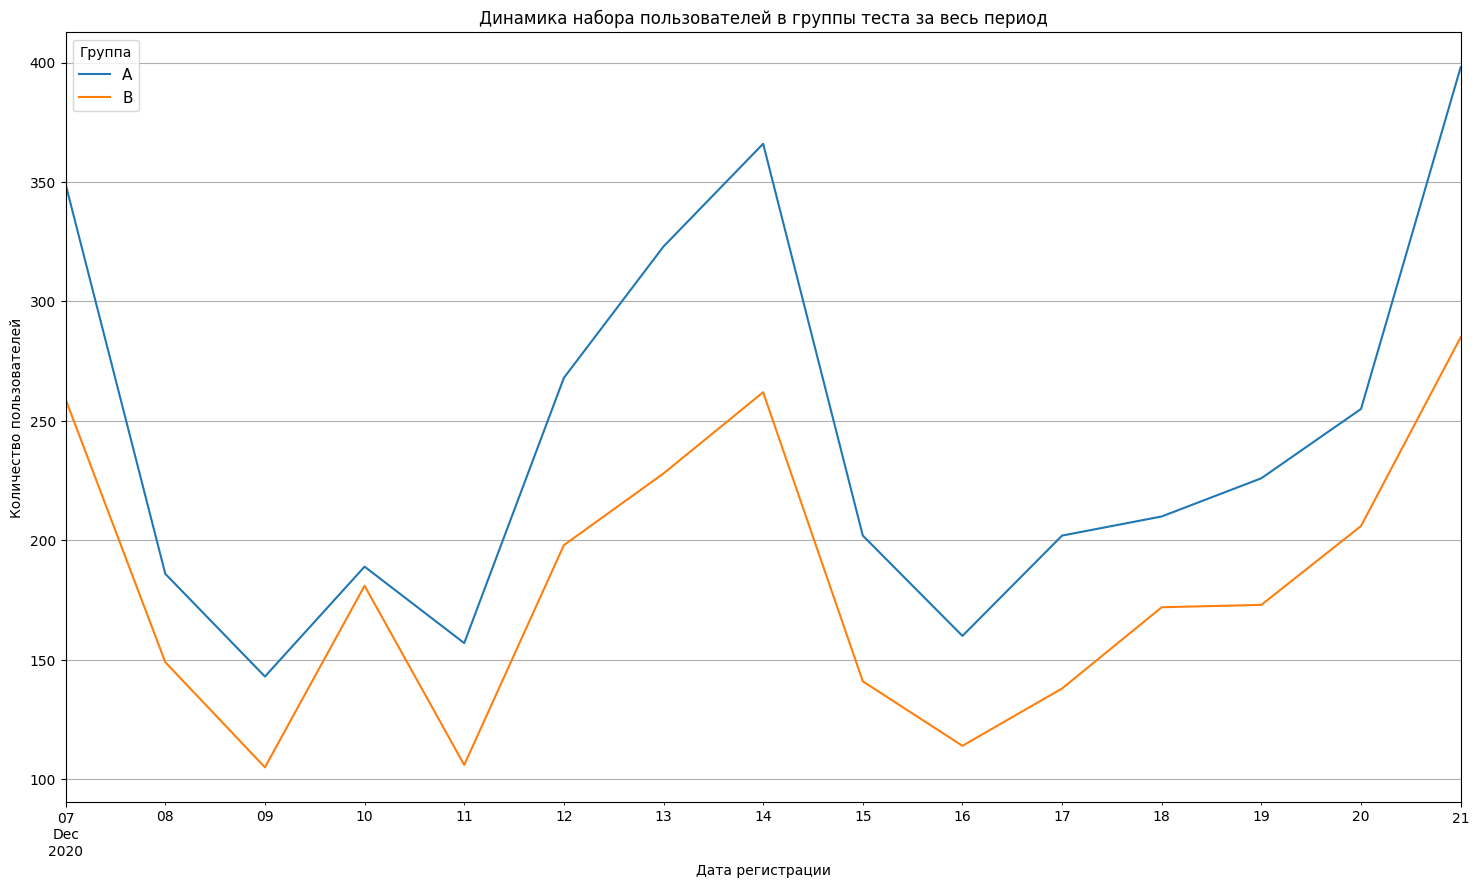

In [118]:
pivot_eu_rst.plot(grid=True)
plt.xlabel('Дата регистрации')
plt.ylabel('Количество пользователей')
plt.title('Динамика набора пользователей в группы теста за весь период')
plt.legend(title='Группа', loc='upper left', labels=['A', 'B'], fontsize=11)
plt.show()

Динамика говорит о том, что набор происходит равномерно в плане динамики между группами. Однако, контрольная группа показывает себя немного лучше по показателям количественного роста.

Если говорить о плавности набора в целом, то пики приходятся на начало (7 декабря) набора пользоватей в группы, середину (14 декабря) и конец (21 декабря).

### Равномерность распределения пользователей по группам теста

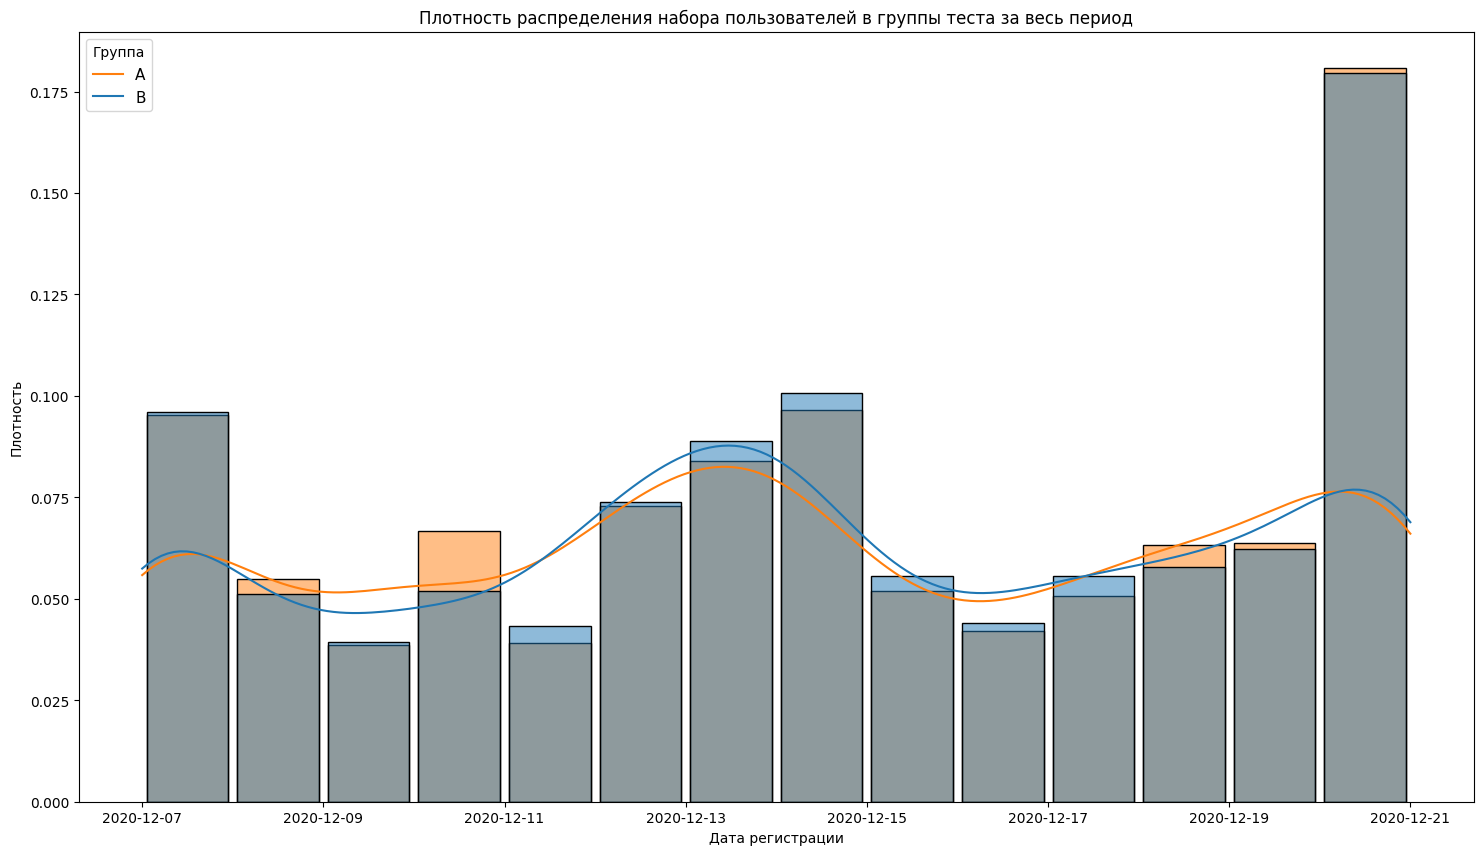

In [119]:
sns.histplot(data=eu_rst,
             x='first_date',
             binwidth=1,
             stat='density',
             common_norm=False,
             hue='group',
#             multiple='dodge',
             shrink=0.9,
             kde=True)
plt.title('Плотность распределения набора пользователей в группы теста за весь период')
plt.xlabel('Дата регистрации')
plt.ylabel('Плотность')
plt.legend(title='Группа', loc='upper left', labels=['A', 'B'], fontsize=11)
plt.show()

По графику распределения видно, что набор пользователей в группы происходит равномерно.

### Пересечение пользователей

Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

#### Пересечение пользователей с конкурирующим тестом

Проверим пользователей на фактор участия в нескольких тестах одновременно. Выделим наборы пользователей с тестами `recommender_system_test` и `interface_eu_test` и посмотрим их пересечение по `user_id`.

In [120]:
crossing_tests = eu_rst[eu_rst['user_id'].isin(iet_participants['user_id'])]
print(f"Количество пользователей, принимающих участие в конкурирующем тесте: {len(crossing_tests['user_id'].unique())}. \
Доля: {len(crossing_tests)/len(eu_rst):.2%}.")


Количество пользователей, принимающих участие в конкурирующем тесте: 1602. Доля: 25.22%.


In [121]:
groupby_eu_rst['%'] = round(groupby_eu_rst['user_id'] / groupby_eu_rst['user_id'].sum(), 3) * 100
groupby_eu_rst

,user_id,%
group,,
A,3634,57.20
B,2717,42.80


25,2% пользователей участвующих в тесте входят также в конкурирующий тест, что по факту является нарушением.

Удаление их из теста невозможно, т.к. это исказит результаты исследования. Основная доля проблемных пользователей приходится на группу А, которая как раз и немного лидировала по количеству на графике динамики - разница с группой B составляет почти 15%.

#### Пересечение пользователей по группам

Проверим пользователей участвовавших в тесте `recommender_system_test` на фактор попадания в обе группы теста.



In [122]:
eu_rst_A = eu_rst[eu_rst['group'] == 'A']
eu_rst_B = eu_rst[eu_rst['group'] == 'B']
crossing_groups = eu_rst_A[eu_rst_A['user_id'].isin(eu_rst_B['user_id'])]
print(f"Количество пользователей, принимающих участие в конкурирующем тесте: {len(crossing_groups['user_id'].unique())}. \
Доля: {len(crossing_groups)/len(eu_rst):.2%}.")

Количество пользователей, принимающих участие в конкурирующем тесте: 0. Доля: 0.00%.


Пересечение участников теста между группами отсутствует, что на самом деле гораздо важнее, чем пересечение между тестами, даже конкурирующими.

### Исследование пользовательской активности

#### Даты совершения событий участниками теста

In [123]:
print(f"Первая запись в журнале событий пользователей: {events['event_dt'].min()}.")
print(f"Последняя запись в журнале событий  пользователей: {events['event_dt'].max()}.")

Первая запись в журнале событий пользователей: 2020-12-07 00:00:33.
Последняя запись в журнале событий  пользователей: 2020-12-30 23:36:33.


In [124]:
rst = pd.merge(events, eu_rst,
               on = 'user_id',
               how='right'
              )
rst

,user_id,event_dt,event_name,details,group,first_date,device
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99,A,2020-12-07,PC
1,D1ABA3E2887B6A73,2020-12-25 00:04:56,purchase,4.99,A,2020-12-07,PC
2,D1ABA3E2887B6A73,2020-12-07 14:43:29,product_cart,NaN,A,2020-12-07,PC
3,D1ABA3E2887B6A73,2020-12-25 00:04:57,product_cart,NaN,A,2020-12-07,PC
4,D1ABA3E2887B6A73,2020-12-07 14:43:27,product_page,NaN,A,2020-12-07,PC
...,...,...,...,...,...,...,...
26285,80712ED4EA1B52A5,2020-12-15 20:10:06,product_page,NaN,A,2020-12-14,Android
26286,80712ED4EA1B52A5,2020-12-20 20:01:34,product_page,NaN,A,2020-12-14,Android
26287,80712ED4EA1B52A5,2020-12-14 05:48:50,login,NaN,A,2020-12-14,Android
26288,80712ED4EA1B52A5,2020-12-15 20:10:03,login,NaN,A,2020-12-14,Android


In [125]:
pre_eda(rst)

user_id: ['D1ABA3E2887B6A73' 'A7A3664BD6242119' 'DABC14FDDFADD29E' ...
 'E26F13A65CEAC6EA' '95401934D6D6D4FC' '80712ED4EA1B52A5']
event_dt: <DatetimeArray>
['2020-12-07 14:43:27', '2020-12-25 00:04:56', '2020-12-07 14:43:29',
 '2020-12-25 00:04:57', '2020-12-20 15:46:06', '2020-12-21 00:40:59',
 '2020-12-25 05:19:45', '2020-12-20 15:46:02', '2020-12-21 00:40:58',
 '2020-12-08 11:30:58',
 ...
 '2020-12-19 23:30:22', '2020-12-20 18:41:25', '2020-12-13 09:55:48',
 '2020-12-14 05:48:50', '2020-12-15 20:10:05', '2020-12-20 20:01:34',
 '2020-12-14 05:48:51', '2020-12-15 20:10:06', '2020-12-15 20:10:03',
 '2020-12-20 20:01:32']
Length: 15629, dtype: datetime64[ns]
event_name: ['purchase' 'product_cart' 'product_page' 'login' nan]
details: [ 99.99   4.99    nan   9.99 499.99]
group: ['A' 'B']
first_date: <DatetimeArray>
['2020-12-07 00:00:00', '2020-12-20 00:00:00', '2020-12-08 00:00:00',
 '2020-12-14 00:00:00', '2020-12-16 00:00:00', '2020-12-17 00:00:00',
 '2020-12-09 00:00:00', '2020-12-13 

,count_unique,nan,"nan, %",duplicates,"duplicates, %"
user_id,6351,0,0.00,19939,75.84
event_dt,15628,2870,10.92,10661,40.55
event_name,4,2870,10.92,26285,99.98
details,4,23094,87.84,26285,99.98
group,2,0,0.00,26288,99.99
first_date,15,0,0.00,26275,99.94
device,4,0,0.00,26286,99.98


По первичному анализу видно, что в тесте повторяется множество событий со стороны одного пользователя, что влечет за собой появление множества события, т.к. он имеет много дубликатов из-за частоты событий. Это похоже на какую-то техническую ошибку.

In [126]:
print(f"Первая запись события в тесте: {rst['event_dt'].min()}.")
print(f"Последняя запись события в тесте: {rst['event_dt'].max()}.")

Первая запись события в тесте: 2020-12-07 00:05:57.
Последняя запись события в тесте: 2020-12-30 12:42:57.


По какой-то из причин тест завершился на 5 дней раньше положенной даты (4 января 2021), что совсем не соответсвует ТЗ в отличии от лишних 2-х дней открытой регистрации. Возможно, что это какая-то техническая ошибка, либо тест по какой-то из причин решили завершить до Нового года.

#### Совпадение теста с датами проведения маркетинговых событий

Ознакомимся с маркетинговыми кампаниями, который попадают в период проведения теста.

In [127]:
marketing_events.query('"2020-12-07" <= start_dt < "2021-12-31"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Только 2 промо проводилось в этот период и лишь `Christmas&New Year Promo` нас удовлетворяет, т.к. в соответствии с ТЗ нас интерересует Европа `EU`. Это иожет повлиять на результаты теста в обе стороны.

### Анализ пользовательской активности

#### Количество событий

##### Количество событий на пользователя

Создадим таблицу с количеством действий на пользователя, перед тем как перейти к анализу.

In [128]:
count_events_by_group = rst.groupby(['group'])['event_dt'].count().reset_index()
count_events_by_group

,group,event_dt
0,A,18309
1,B,5111


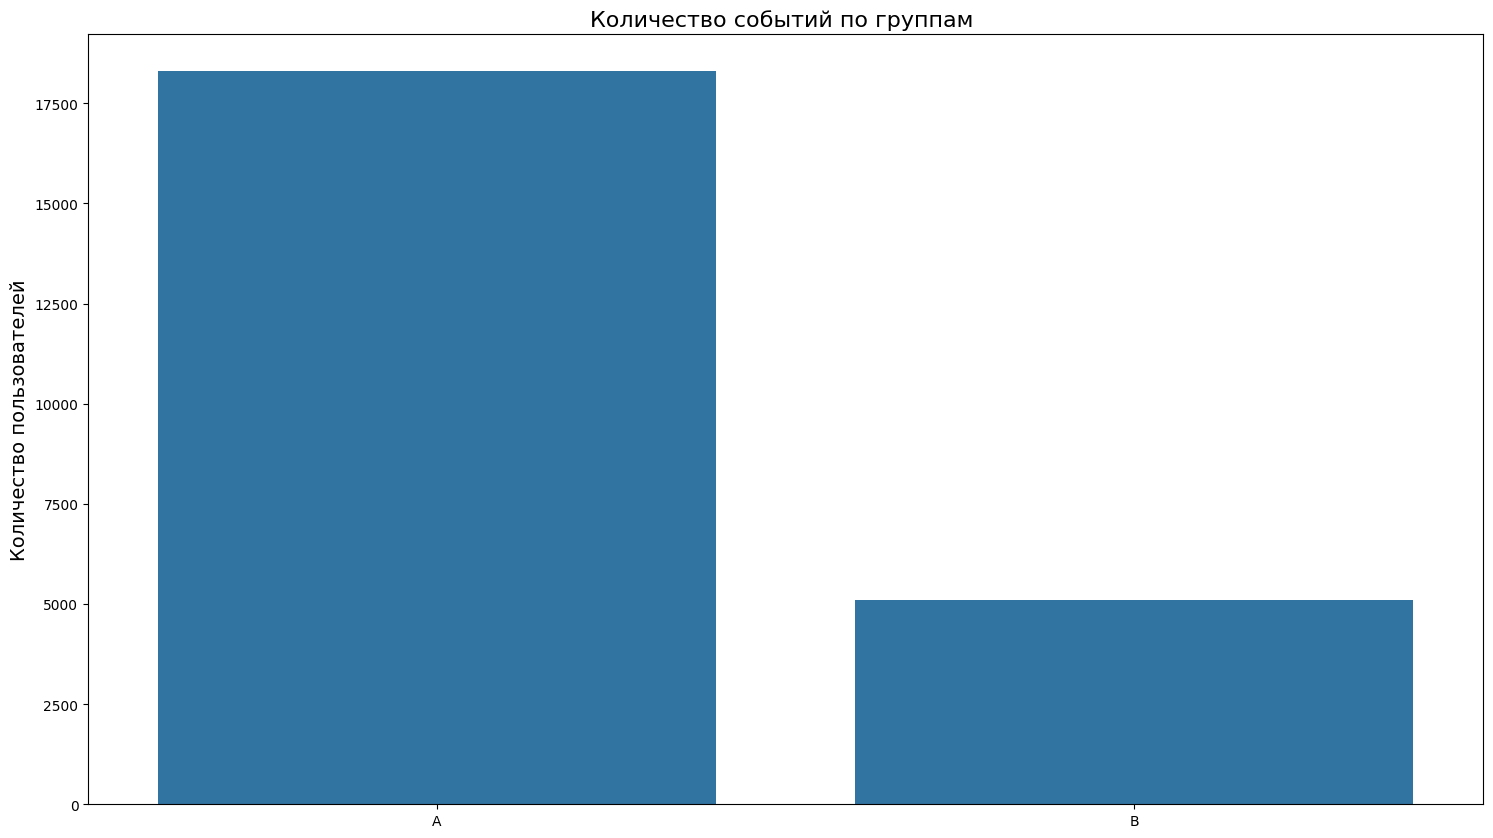

In [129]:
sns.barplot(x='group', y='event_dt', data=count_events_by_group)
plt.title(f'Количество событий по группам ', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.show()

Из графика видно, что в основном события приходятся на группу А, чем на B (18309 и 5111) соответственно.

Теперь сгруппируем пользователей по уникальным значения и группам, чтобы понять сколько событий совершают пользователи.

In [130]:
count_events_by_user = rst.groupby(['user_id', 'group'])['event_dt'].count().reset_index()
count_events_by_user.head()

,user_id,group,event_dt
0,000ABE35EE11412F,A,0
1,001064FEAAB631A1,B,6
2,0010A1C096941592,A,12
3,001C05E87D336C59,A,0
4,00341D8401F0F665,A,2


In [131]:
pivot_events_by_user = count_events_by_user.pivot_table(
    index = 'event_dt', columns = 'group', values = 'user_id', aggfunc = 'count')
pivot_events_by_user.head()

group,A,B
event_dt,,
0,"1,030.00","1,840.00"
1,34.00,17.00
2,189.00,107.00
3,229.00,121.00
4,415.00,172.00


In [132]:
fig = px.box(count_events_by_user, x="event_dt")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха количества событий',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[-1, count_events_by_user['event_dt'].median()*8],
                  xaxis_title='Количество событий',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.update_layout(width=1000, height=600)
fig.show()

fig = px.box(count_events_by_user, x="event_dt", color="group")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха количества событий в группах А и В',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[-1, count_events_by_user['event_dt'].median()*11],
                  xaxis_title='Количество событий',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.update_layout(width=1000, height=600)
fig.show()

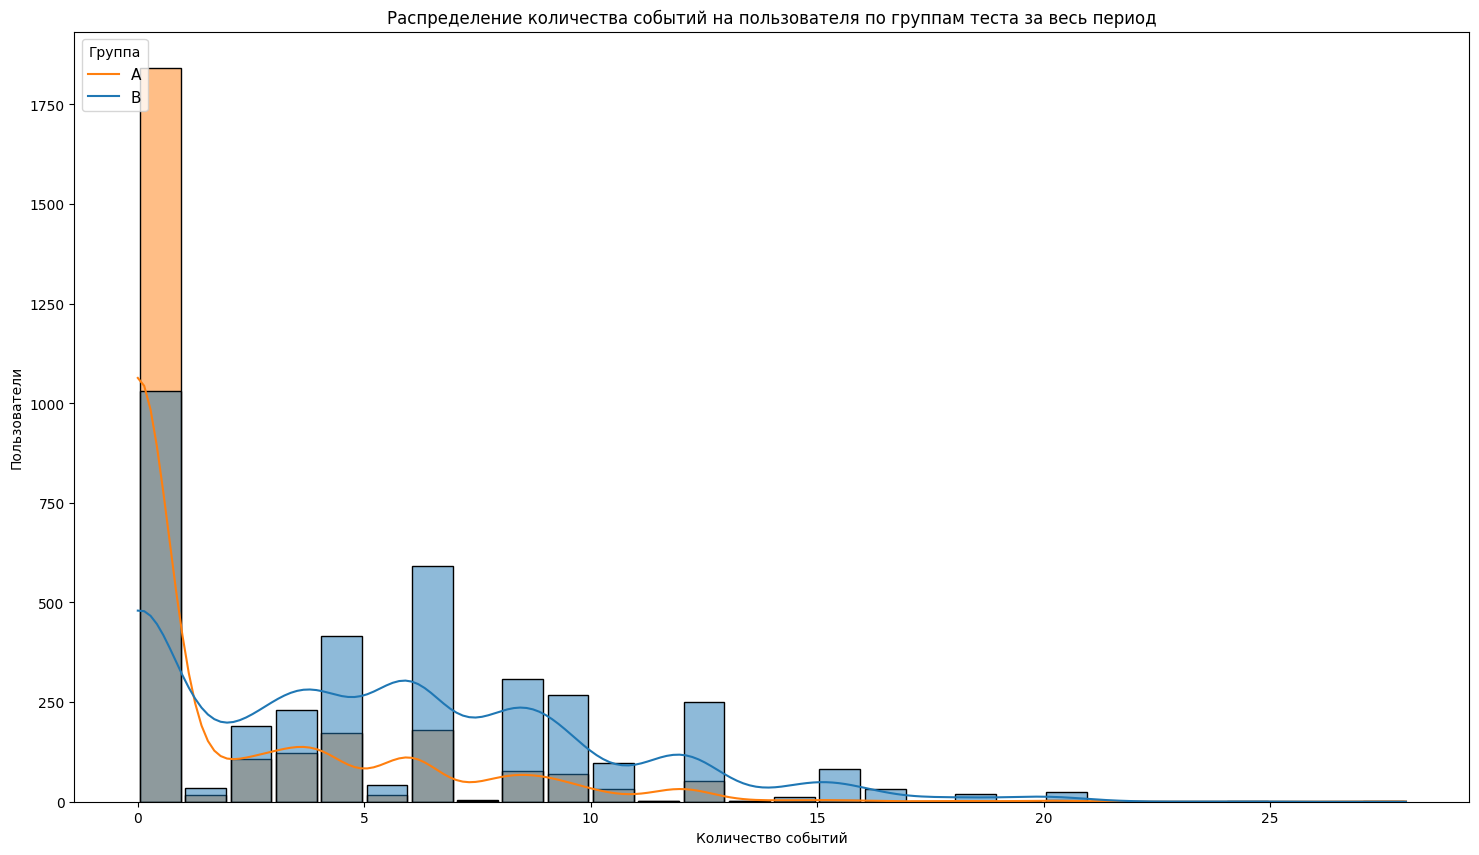

In [133]:
sns.histplot(data=count_events_by_user,
             x='event_dt',
             binwidth=1,
#             stat='density',
             common_norm=False,
             hue='group',
#             multiple='dodge',
             shrink=0.9,
             kde=True)
plt.title('Распределение количества событий на пользователя по группам теста за весь период')
plt.xlabel('Количество событий')
plt.ylabel('Пользователи')
plt.legend(title='Группа', loc='upper left', labels=['A', 'B'], fontsize=11)
plt.show()

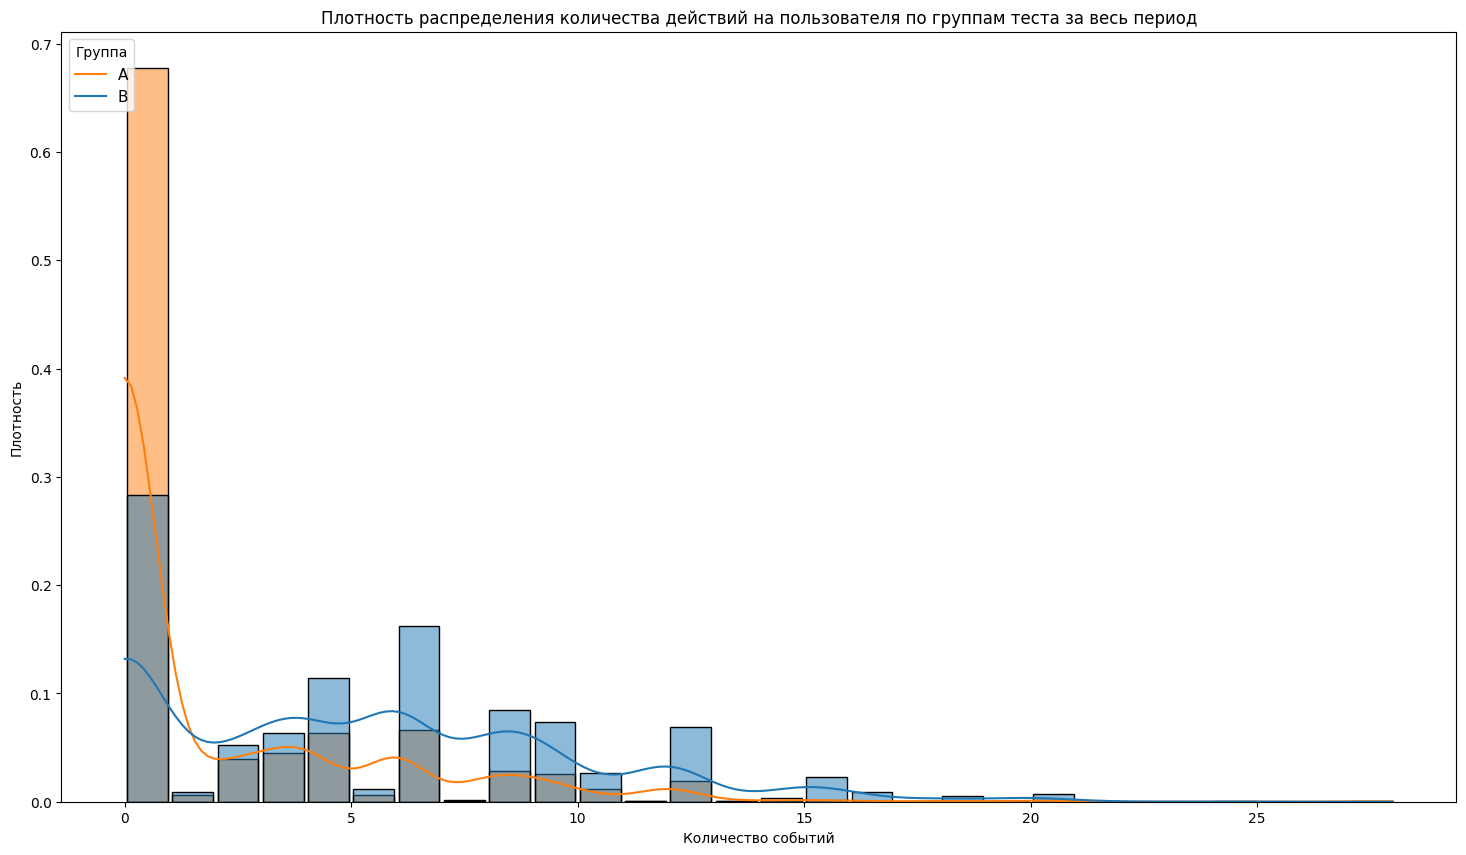

In [134]:
sns.histplot(data=count_events_by_user,
             x='event_dt',
             binwidth=1,
             stat='density',
             common_norm=False,
             hue='group',
#             multiple='dodge',
             shrink=0.9,
             kde=True)
plt.title('Плотность распределения количества действий на пользователя по группам теста за весь период')
plt.xlabel('Количество событий')
plt.ylabel('Плотность')
plt.legend(title='Группа', loc='upper left', labels=['A', 'B'], fontsize=11)
plt.show()

**Вывод:**
- Есть пользователи без событий;
- Среднее количество действий на пользователя: 4;
- Среднее количество действий на пользователя в группе A выше, чем B (5 и 2 соответственно);
- По динамике группа А опрежает группу В. Это связано с небольшой разницой в количестве;
- Распределение показывает, что группа B имеет больше событий на пользователя;
- Плотность распределения почти равномерная, но  лидирует группа А.

##### Пользователи без событий

In [135]:
inactive_users = count_events_by_user.query('event_dt < 1')
inactive_users = rst[rst['user_id'].isin(inactive_users['user_id'])]
print(f'Количество пользователей без событий: {len(inactive_users)}')

Количество пользователей без событий: 2870


Визуализируем разбивку пользователей без по группам.

In [136]:
inactive_users_by_group = inactive_users.groupby(['group'])['user_id'].count().reset_index()
inactive_users_by_group

,group,user_id
0,A,1030
1,B,1840


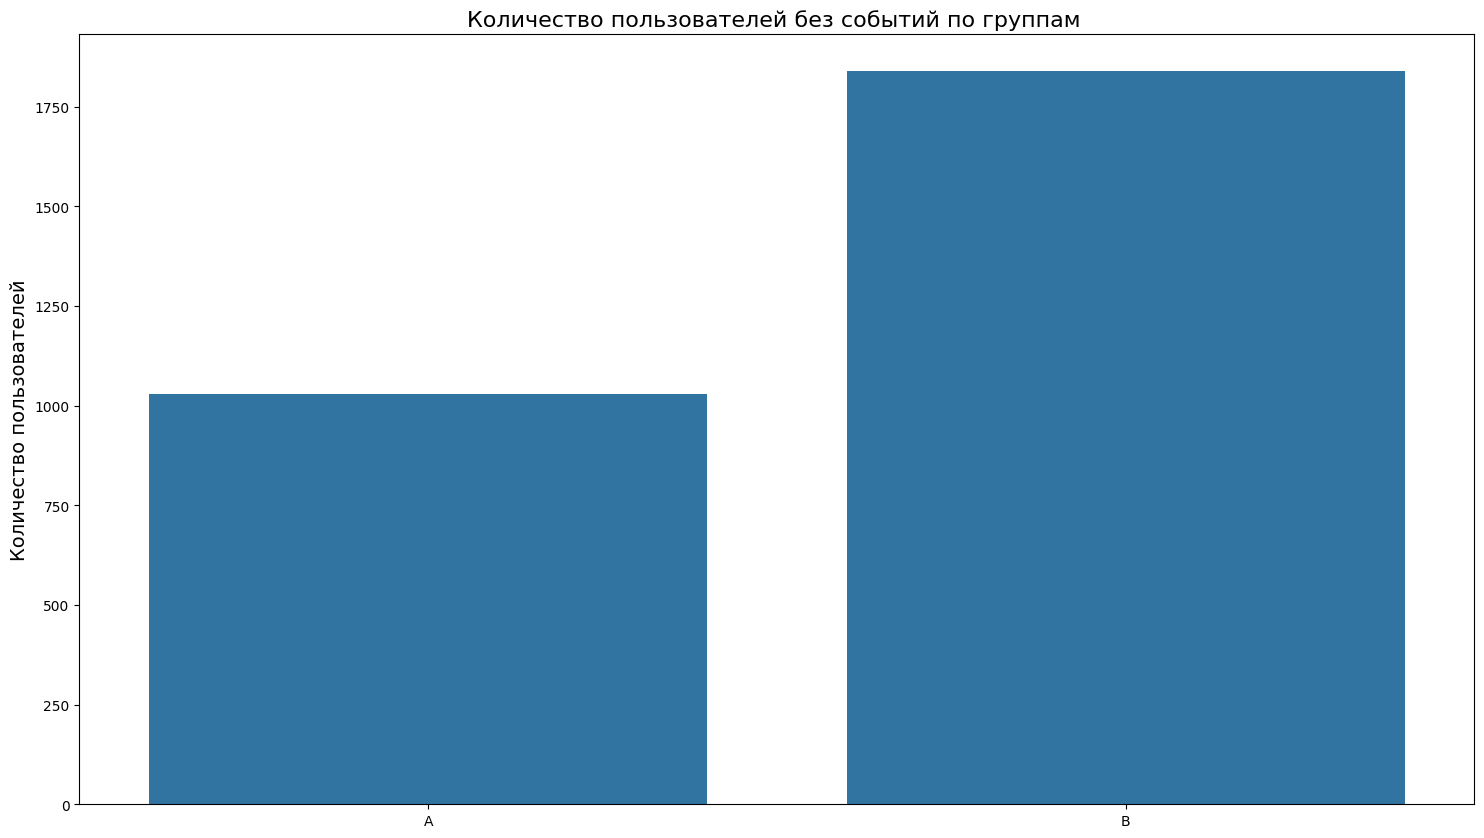

In [137]:
sns.barplot(x='group', y='user_id', data=inactive_users_by_group)
plt.title(f'Количество пользователей без событий по группам ', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.show()

На графика видно, что пользователей без событий, т.е. после регистрации значительно больше в тестовой группе, чем в контрольной (1030 против 1840 соответствено).

Чтобы выяснить возможные причины появления, изучим динамику регистрации пользователей по группам как без событий, так и с событиями.

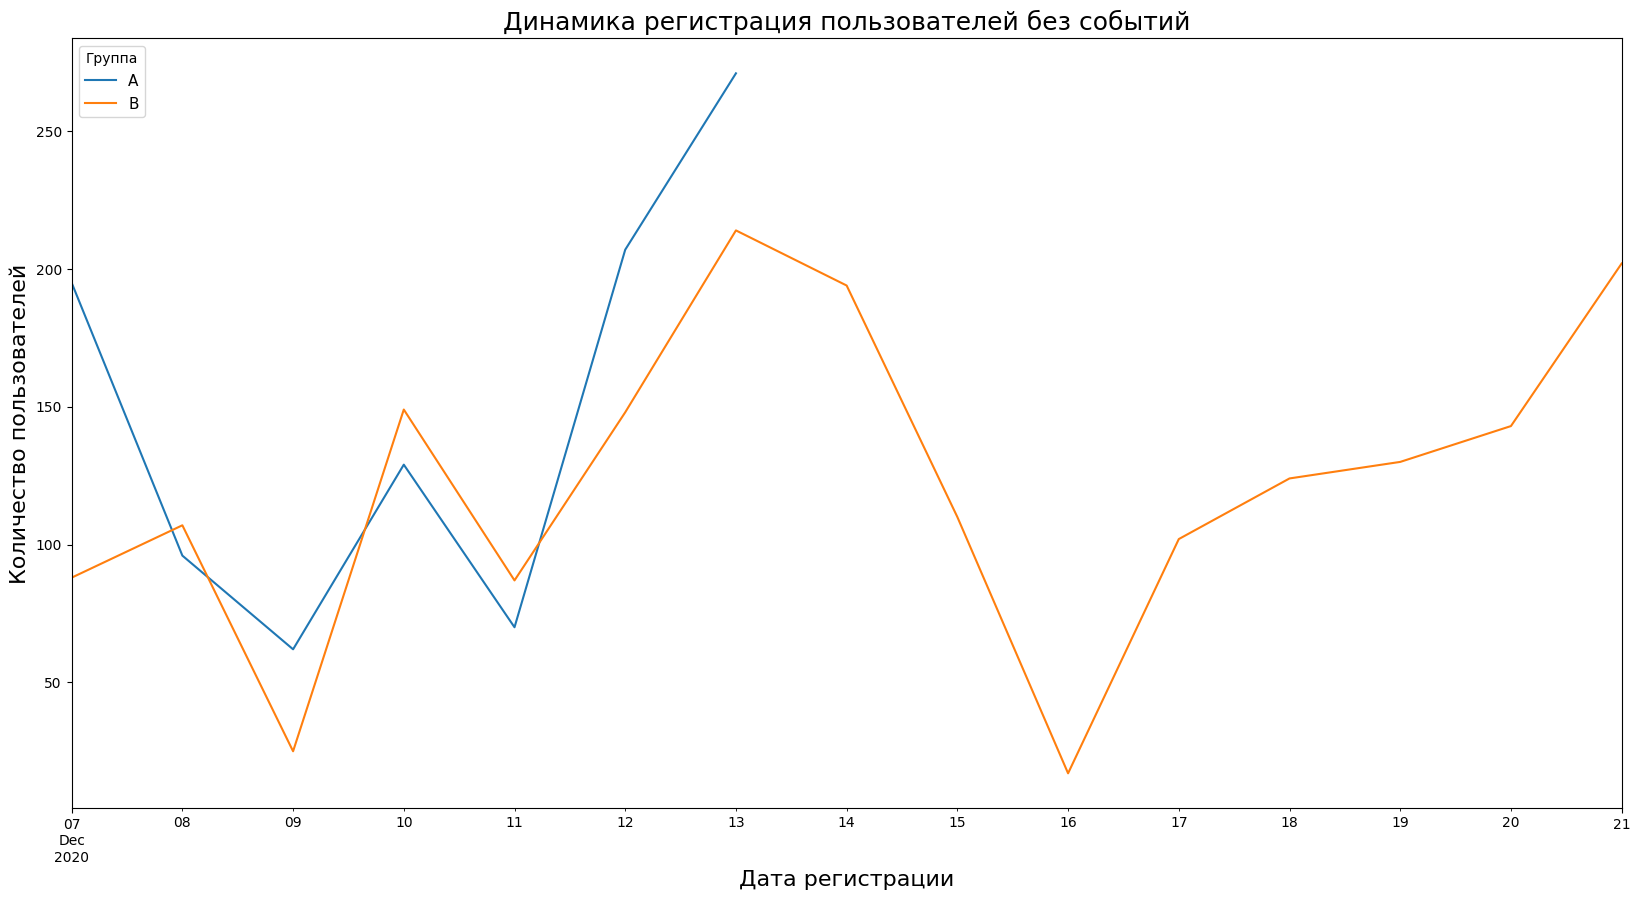

In [138]:
inactive_users.pivot_table(index='first_date',
                               columns='group',
                               values='user_id',
                               aggfunc='nunique'
                              ).plot(figsize=(20, 10))
plt.ylabel('Количество пользователей', fontsize=16)
plt.xlabel('Дата регистрации', fontsize=16)
plt.title('Динамика регистрация пользователей без событий', fontsize=18)
plt.legend(title='Группа', loc='upper left', labels=['A', 'B'], fontsize=11)
plt.show()

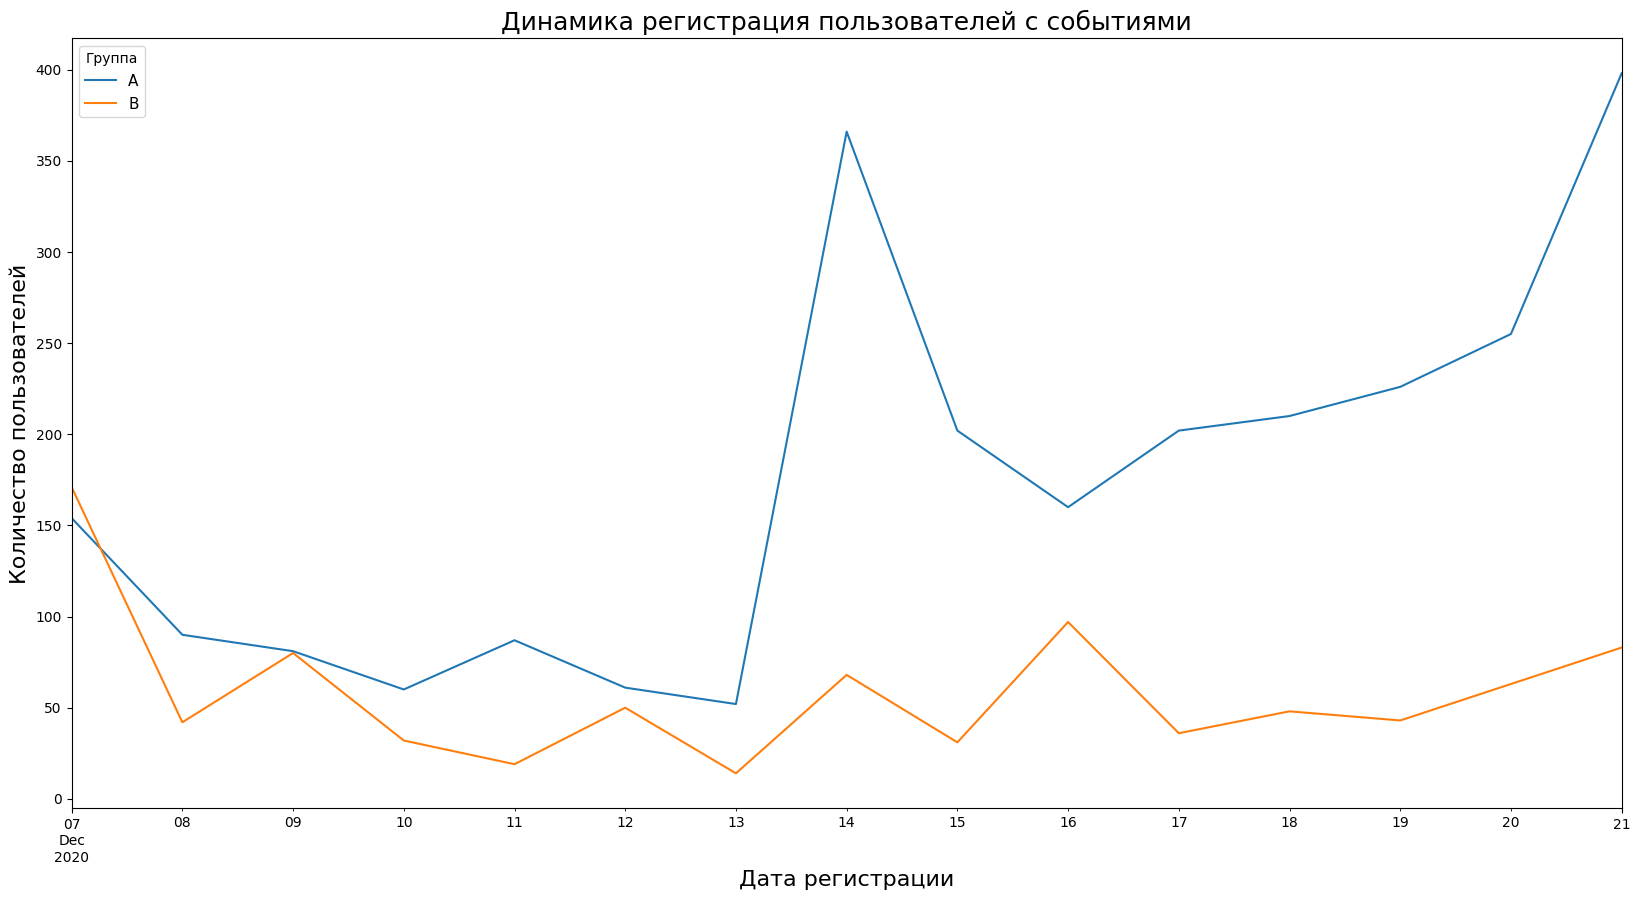

In [139]:
active_users = rst[~rst['user_id'].isin(inactive_users['user_id'])]
active_users.pivot_table(index='first_date',
                               columns='group',
                               values='user_id',
                               aggfunc='nunique'
                              ).plot(figsize=(20, 10))
plt.ylabel('Количество пользователей', fontsize=16)
plt.xlabel('Дата регистрации', fontsize=16)
plt.title('Динамика регистрация пользователей с событиями', fontsize=18)
plt.legend(title='Группа', loc='upper left', labels=['A', 'B'], fontsize=11)
plt.show()

Пользователи без событий в группе A перестали регистрироваться с 14-го декабря. Также после этой даты наблюдается пик пользователей с событиями. Скорее всего произошла ошибка при сборе данных, поэтому от таких пользователей стоит избавиться, т.к. они могут исказить результаты тестирования.

In [140]:
rst = rst[~rst['user_id'].isin(inactive_users['user_id'])]

**Вывод:**

- Возможно, что был сбой и пользователей попросился зарегистриваться вновь, в следствие чего случился пик активности по событиям внутри группы А.
- Самый пик регистраций приходится на последний день.
- Количество активных пользователей группы B намного ниже, чем тех, кто без событий.
- Избавились от бездействующих пользователей.

##### Количество событий в группах А и В по типу события

In [141]:
type_events_by_user = (rst.groupby(['user_id', 'event_name'], as_index=False)['device'].count()
                              .rename(columns={'device':'events_count'})
                              .merge(rst[['user_id', 'group']], on='user_id')
                              .drop_duplicates())
type_events_by_user.head()

,user_id,event_name,events_count,group
0,001064FEAAB631A1,login,3,B
6,001064FEAAB631A1,product_page,3,B
12,0010A1C096941592,login,4,A
24,0010A1C096941592,product_page,4,A
36,0010A1C096941592,purchase,4,A


In [142]:
fig = px.box(type_events_by_user, x="event_name", y="events_count", color="group", color_discrete_sequence=["red", "blue"])
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха количества событий в группах А и В по типу события',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_title='Наименование событий',
                  yaxis_title='Количество события')
fig.update_traces(boxmean=True)
fig.update_layout(width=1000, height=800)

fig.show()

**Вывод:**
- Обе группы имеют почти одинаковое среднее количество авторизаций;
- События, связанные с карточками товаров, корзиной и покупками и конверсией в события корзины товара у группы А примерно на 50% больше, чем у группы B.

Вполне возможно, что есть какая-то проблема с путем, который проходит покупатель, т.к. на этапе фильтрации у нас было почти 6,5 тыс. человек в рамках теста, а с добавлением событий количество уникальных пользователей сильно сократилось.

#### Жизненный цикл (лайфтайм) событий

Лайфтайм совершения события пользователем после регистрации — события, которые были совершены в первые 14 дней с момента регистрации

In [143]:
horizon_days = 14 # горизонт анализа
observation_date = datetime(2021, 1, 4).date() # момент анализа
last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)

rst_before = rst['user_id'].nunique()
rst = rst.copy()
rst['lifetime'] = (rst['event_dt'] - rst['first_date']).dt.days
rst = rst.query('lifetime <= 14')
total_users_after = rst['user_id'].nunique()
rst_diff = (rst_before - total_users_after) / rst_before * 100
print(f'Количество уникальных пользователей до фильтрации: {rst_before}')
print(f'Количество уникальных пользователей после фильтрации: {total_users_after}')
print(f'Процент потерь среди уникальных пользователей: {rst_diff:.2%}.')

Количество уникальных пользователей до фильтрации: 3481
Количество уникальных пользователей после фильтрации: 3481
Процент потерь среди уникальных пользователей: 0.00%.


In [144]:
print(f"Первая запись в журнале событий пользователей: {rst['event_dt'].min()}.")
print(f"Последняя запись в журнале событий  пользователей: {rst['event_dt'].max()}.")

Первая запись в журнале событий пользователей: 2020-12-07 00:05:57.
Последняя запись в журнале событий  пользователей: 2020-12-29 23:38:29.


In [145]:
lifetime_by_user = rst.groupby(['user_id', 'group'])['lifetime'].count().reset_index()
lifetime_by_user.head()

,user_id,group,lifetime
0,001064FEAAB631A1,B,6
1,0010A1C096941592,A,12
2,00341D8401F0F665,A,2
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5


In [146]:
lifetime_by_event = rst.groupby(['event_dt', 'group'])['lifetime'].count().reset_index()
lifetime_by_event.head()

,event_dt,group,lifetime
0,2020-12-07 00:05:57,B,2
1,2020-12-07 00:07:47,B,2
2,2020-12-07 00:07:48,B,1
3,2020-12-07 00:07:49,B,1
4,2020-12-07 00:14:01,A,2


In [147]:
fig = px.box(lifetime_by_user, x="lifetime")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха жизненного цикла на пользователя',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[-1, count_events_by_user['event_dt'].median()*9],
                  xaxis_title='Дни',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.update_layout(width=1000, height=600)
fig.show()

fig = px.box(lifetime_by_user, x="lifetime", color="group")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха жизненного цикла на пользователя по группам',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[-1, count_events_by_user['event_dt'].median()*9],
                  xaxis_title='Дни',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.update_layout(width=1000, height=600)
fig.show()

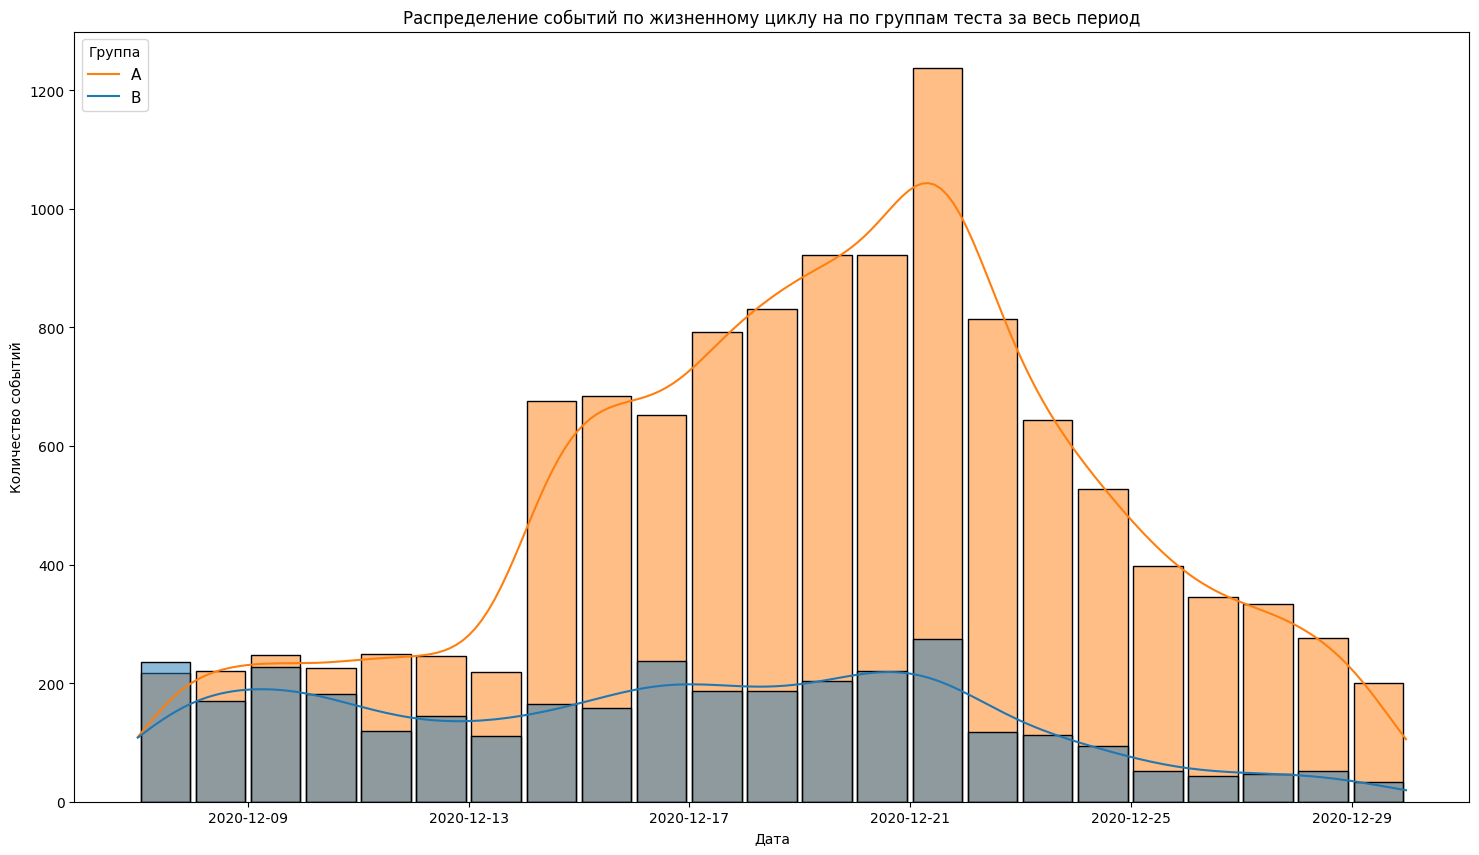

In [148]:
sns.histplot(data=lifetime_by_event,
             x='event_dt',
             binwidth=1,
#             stat='density',
             common_norm=False,
             hue='group',
#             multiple='dodge',
             shrink=0.9,
             kde=True)
plt.title('Распределение событий по жизненному циклу на по группам теста за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend(title='Группа', loc='upper left', labels=['A', 'B'], fontsize=11)
plt.show()

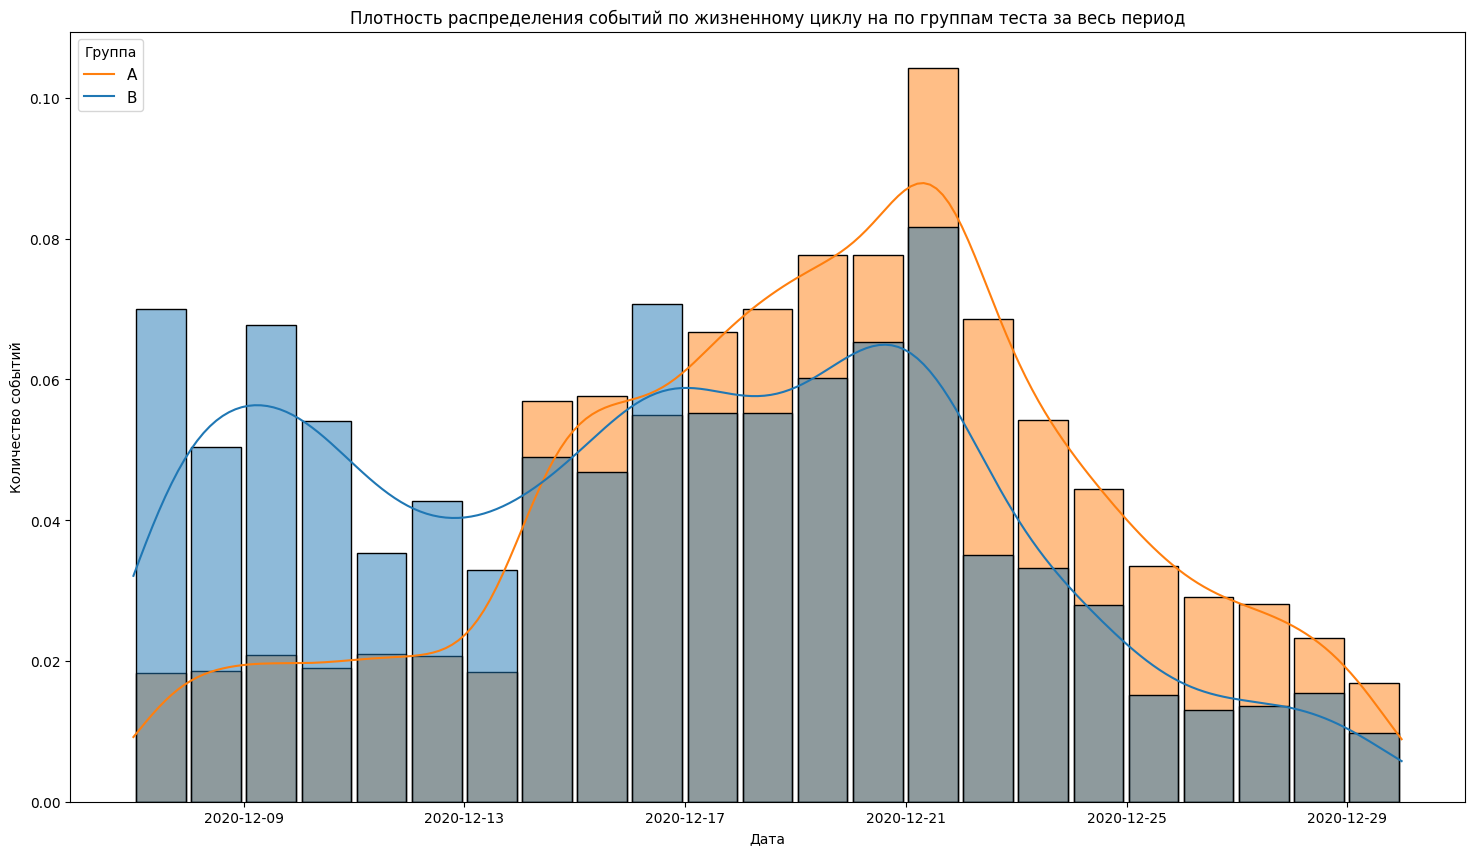

In [149]:
sns.histplot(data=lifetime_by_event,
             x='event_dt',
             binwidth=1,
             stat='density',
             common_norm=False,
             hue='group',
#             multiple='dodge',
             shrink=0.9,
             kde=True)
plt.title('Плотность распределения событий по жизненному циклу на по группам теста за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend(title='Группа', loc='upper left', labels=['A', 'B'], fontsize=11)
plt.show()

- Распределение показывает, что очень много событий приходится на группу А проактически на протяжении всего теста.
- С плотностью немного иначе: до 13 декабря лидирует группа B и распределение неравномерное, а с 14 декабря и до конца теста группа А, но распределение уже практически на одном уровне.
- Пик приходится на 21 декабря, а спад идет после и до конца всего теста.

In [150]:
rst.groupby('group').agg({'user_id' : 'nunique'})

,user_id
group,
A,2604
B,877


In [151]:
rst['lifetime'].describe()

count   22,828.00
mean         2.93
std          3.48
min          0.00
25%          0.00
50%          2.00
75%          5.00
max         14.00
Name: lifetime, dtype: float64

Как видно, `lifetime` среди всех участников теста довольно низкий - среднее значение в районе 3, а количество участников далеко от 6000.

### Мощность теста

- Предполагаемая конверсия — 50%;
- Ожидаемый прирост конверсии — 5% по каждой метрике;

Не смотря на то, что у наас выборка не соответсвует ТЗ, некоторые онлайн-кулькулятор считаю ее достаточной, даже излишне, при конверсии в 50%, прогнозируя конверсию от 45% до 55%. Единственный нюанс в том, что группа имеет недостаточно пользователей.

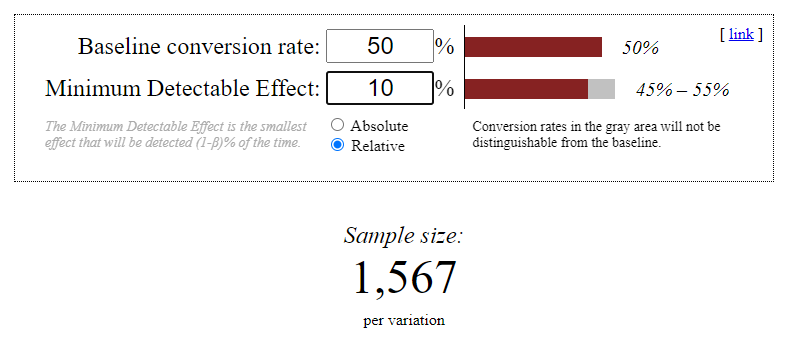

![Текст с описанием картинки](https://i.imgur.com/neweVNX.png)

2 результата из калькулятора говорят о том, что чем больше выборка - тем сложнее добиться увеличения метрик, поэтому вполне возможно, что из-за уменьшения групп выборок у нас получится справиться с этой задачей в соответсвии с ТЗ.

### Вывод

- Количество пользователей участвующих в тесте: 6701. Доля: 10.85%
- Пользователей теста почти в 2 раза меньше по сравнению с конкурирующим.
- Количество зарегистрированных пользователей среди участников теста: 6701.
- Количество тестируемых пользователей не изменилось после разделения, значит все они попали в тест корректно.
- Количество зарегистрированных пользователей из Европы среди участников теста: 6351. Доля: 15.00%. Данный показатель соответсвует ТЗ.
- Набор происходит равномерно в плане динамики. Однако, контрольная группа показывает себя немного лучше по показателям количественного роста.
- Распределение пользователей по группам происходит равномерно.
- Количество пользователей, принимающих участие в конкурирующем тесте: 1602. Доля: 25.22%.
- Пересечение участников теста между группами отсутствует, что на самом деле гораздо важнее, чем пересечение между тестами, даже конкурирующими.
- Тест завершился на 5 дней раньше положенной даты (4 января 2021), что не соответствует ТЗ.
- Даты проведения теста совпадают с промо `Christmas&New Year Promo`, что не очень хорошо.
- После объединения фрейма с событиями и фильтрации по `lifetime` условие не менее 6000 участников или 15% из Европы не выполняется.
- Видно спад набора групп, а также активности пользователей после двух недель теста, что никак не соответсвует желаемомому `lifetime`.
- `lifetime` составил 3;
- Пиковыми дня являются 14 и 21 декабря;
- Конверсия в группе A составила 74% по отношению ко всем участникам теста.
- Пользователи без событий в группе A перестали регистрироваться с 14-го декабря. Также после этой даты наблюдается пик пользователей с событиями. Скорее всего произошла ошибка при сборе данных.


**Итог:** проведение теста нельзя назвать корректным, т.к. есть много погрешностей при формировании выборок, которые не соответствуют ТЗ.

- Возможно есть проблема с путем, который проходит покупатель, т.к. на этапе фильтрации у нас было почти 6,5 тыс. человек в рамках теста, а с добавлением событий количество уникальных пользователей сильно сократилось. Это говорит о том, что они не дошли до ключевых шагов в рамках тестирования, либо возникли какие-то технические проблемы при сборе данных.
- Возможно, что был сбой и пользователей попросился зарегистриваться вновь, в следствие чего случился пик активности по событиям внутри группы А.
- Самый пик регистраций приходится на последний день.
- Количество активных пользователей группы B намного ниже, чем тех, кто без событий.

## Исследовательский анализ



* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
    * конверсии в просмотр карточек товаров — событие `product_page`
    * просмотры корзины — `product_cart`
    * покупки — `purchase`.

### Распределение количества событий на пользователя в разрезе групп теста

In [152]:
count_events_by_user = rst.groupby(['user_id', 'group'])['event_dt'].count().reset_index()
count_events_by_user.head()

,user_id,group,event_dt
0,001064FEAAB631A1,B,6
1,0010A1C096941592,A,12
2,00341D8401F0F665,A,2
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5


In [153]:
fig = px.box(count_events_by_user, x="event_dt")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха количества событий',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[-1, count_events_by_user['event_dt'].median()*4],
                  xaxis_title='Количество событий',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.update_layout(width=1000, height=600)
fig.show()

fig = px.box(count_events_by_user, x="event_dt", color="group")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха количества событий в группах А и В',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[-1, count_events_by_user['event_dt'].median()*4],
                  xaxis_title='Количество событий',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.update_layout(width=1000, height=600)
fig.show()

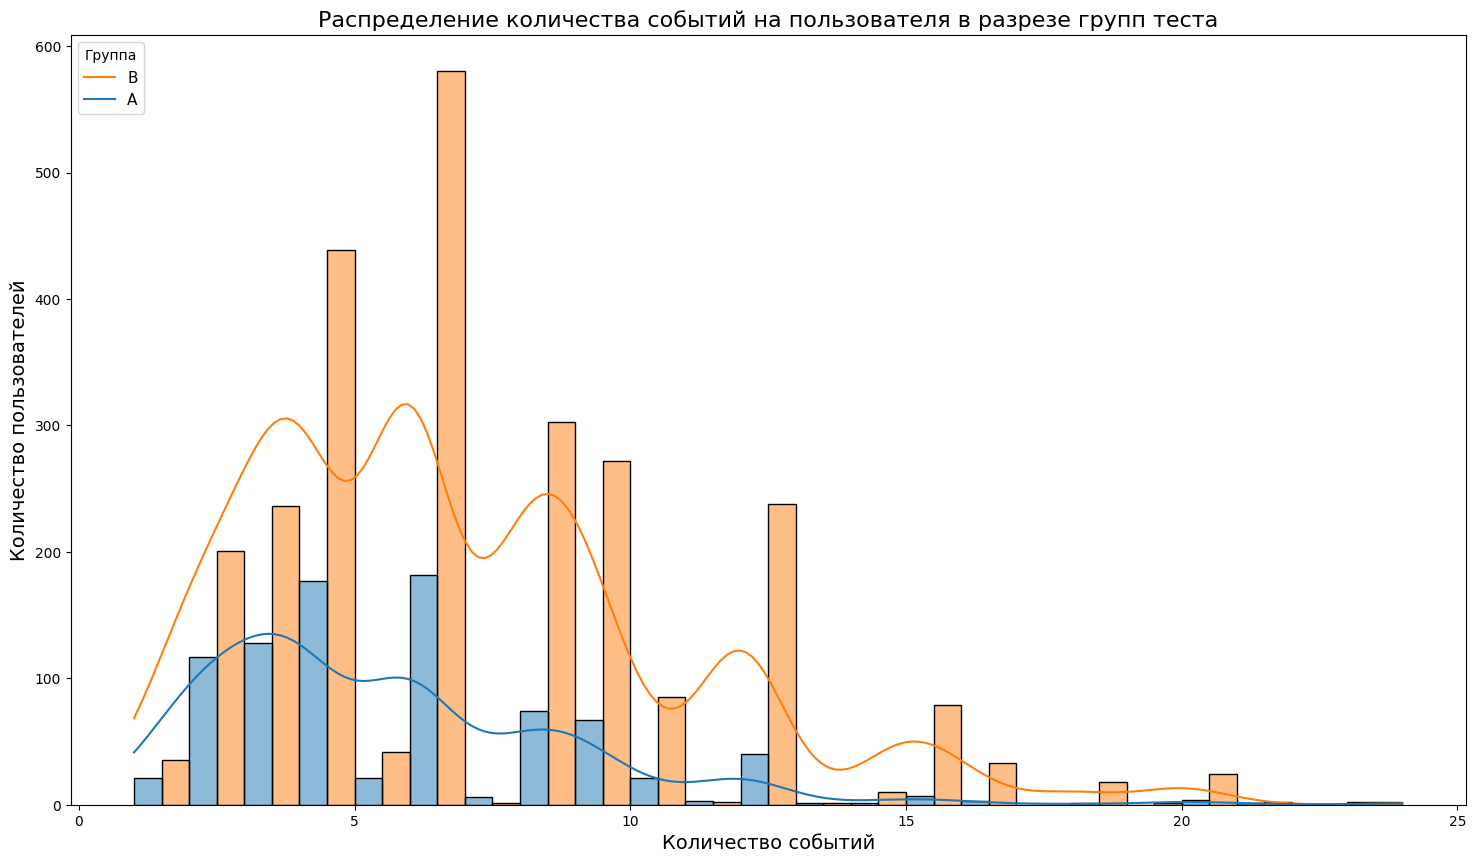

In [154]:
sns.histplot(data=count_events_by_user,
             x='event_dt',
             kde=True, binwidth=1,
             hue="group",
             multiple="dodge"
            )
plt.title('Распределение количества событий на пользователя в разрезе групп теста', fontsize=16)
plt.xlabel('Количество событий', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.legend(title='Группа', loc='upper left', labels=['B', 'A'], fontsize=11)
plt.show()

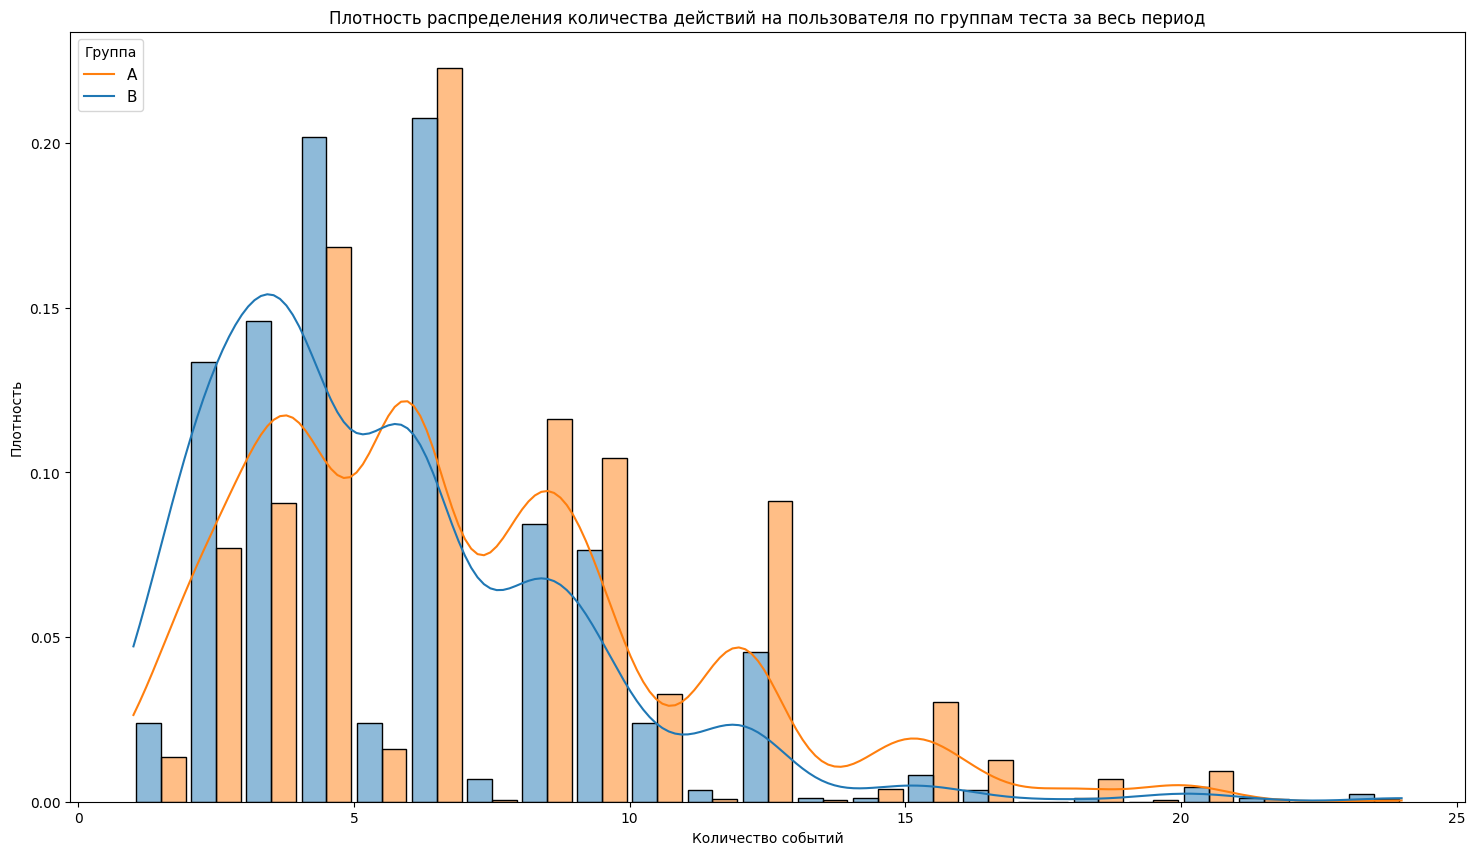

In [155]:
sns.histplot(data=count_events_by_user,
             x='event_dt',
             binwidth=1,
             stat='density',
             common_norm=False,
             hue='group',
             multiple='dodge',
             shrink=0.9,
             kde=True)
plt.title('Плотность распределения количества действий на пользователя по группам теста за весь период')
plt.xlabel('Количество событий')
plt.ylabel('Плотность')
plt.legend(title='Группа', loc='upper left', labels=['A', 'B'], fontsize=11)
plt.show()

**Вывод:**
- У каждого пользователя все также есть минимум 1 событие;
- Среднее количество действий на пользователя: 5;
- Среднее количество действий на пользователя в группе A  составляет 7, а в группе B - 5;
- Распределение показывает, что группа B показывает себя лучше группы A;
- Плотность распределения почти равномерная, но группа B иногда вырывается по отношению к группе А.

### Распределение количества событий на пользователя в разрезе групп теста по дням

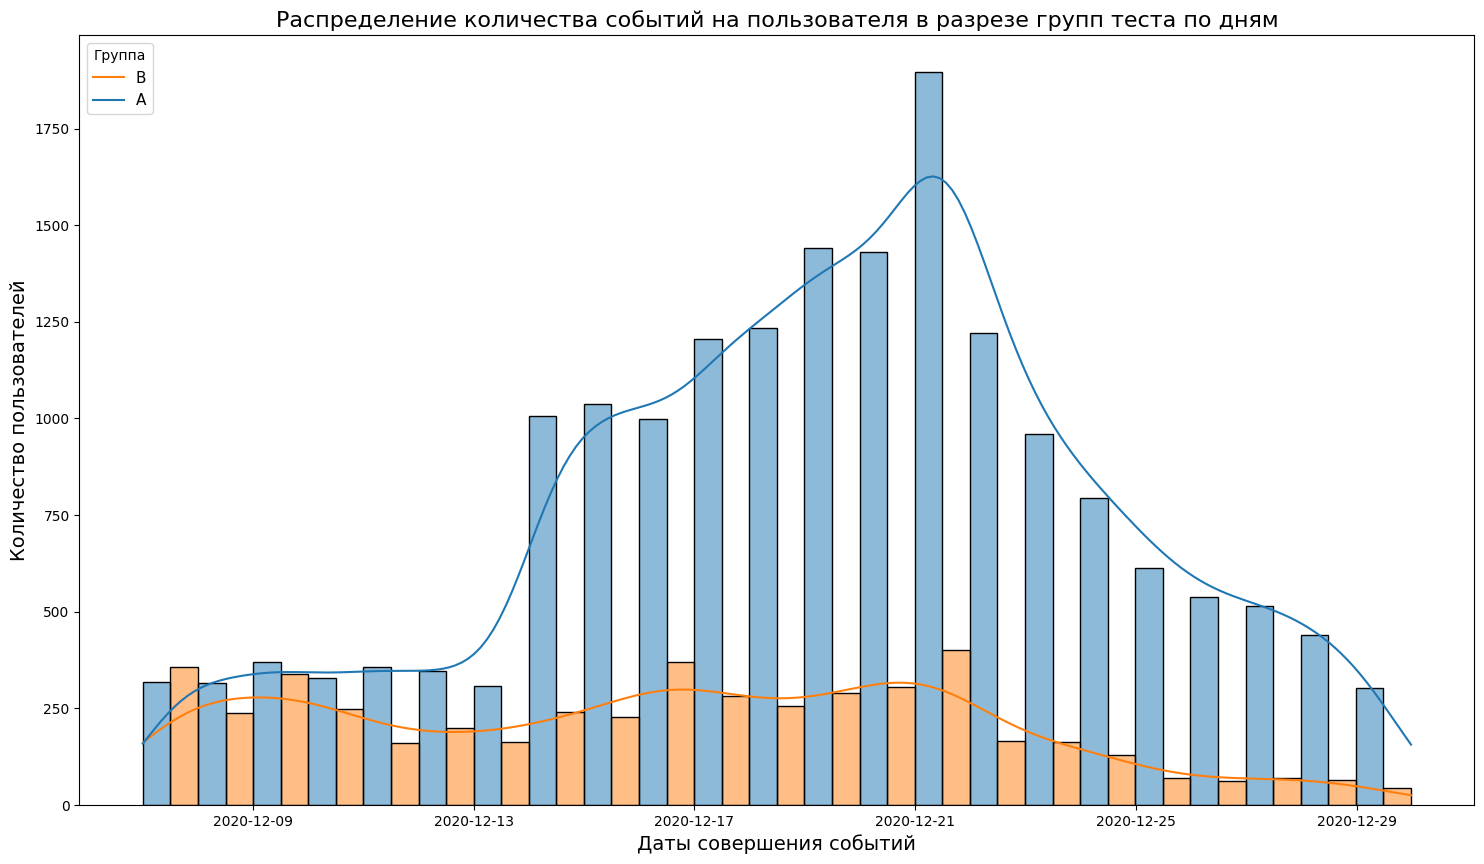

In [156]:
sns.histplot(data=rst,
             x="event_dt",
             kde=True, binwidth=1,
             hue="group",
             multiple="dodge"
            )
plt.title('Распределение количества событий на пользователя в разрезе групп теста по дням', fontsize=16)
plt.xlabel('Даты совершения событий', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.legend(title='Группа', loc='upper left', labels=['B', 'A'], fontsize=11)
plt.show()

In [157]:
rst['day'] = rst['event_dt'].dt.date
event_by_day = rst.groupby(['day', 'group'])['event_name'].count().reset_index()

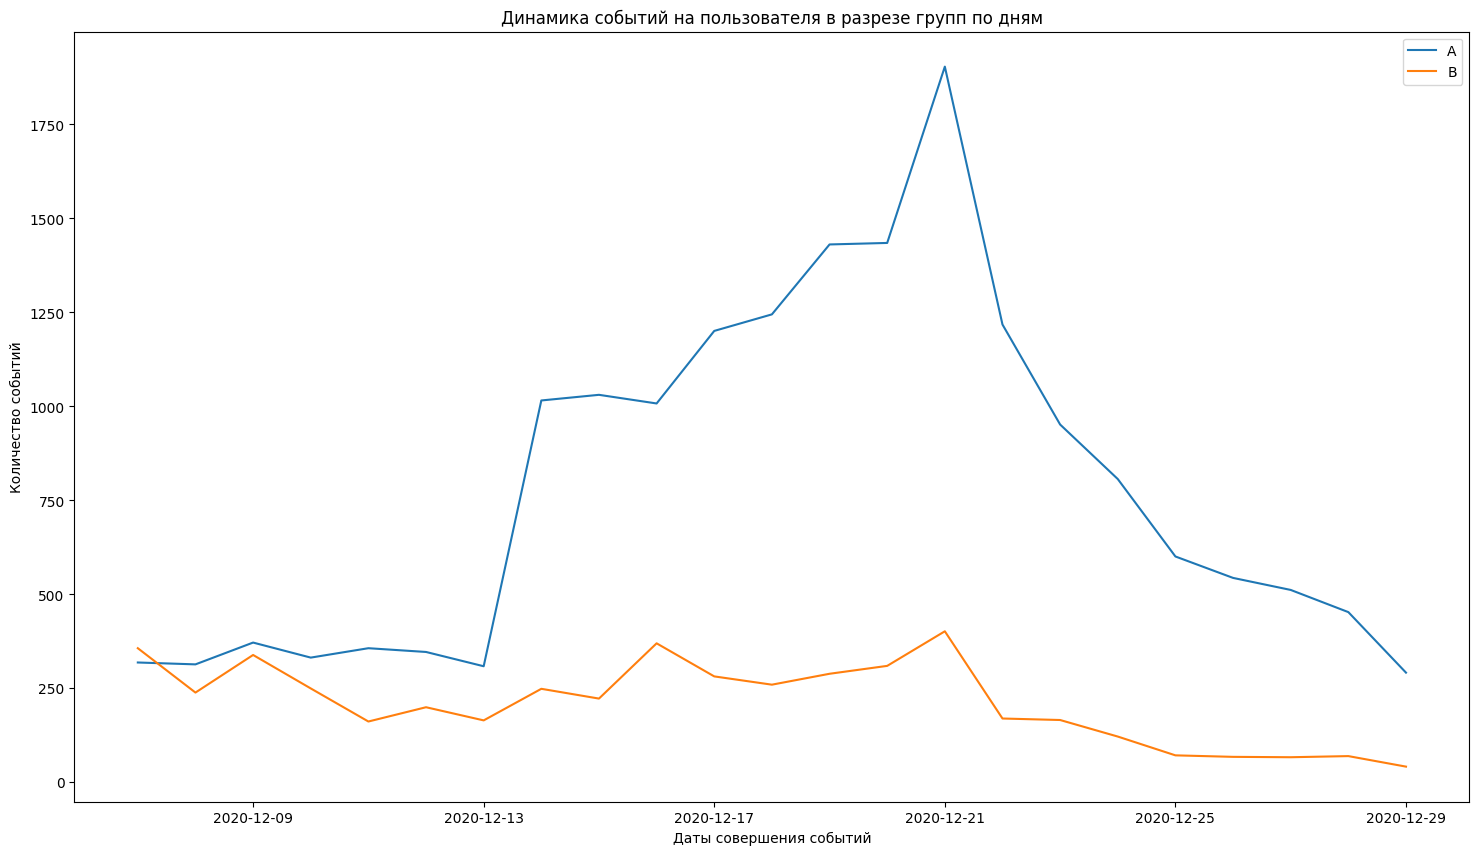

In [158]:
sns.lineplot(x = 'day', y = 'event_name', data=event_by_day.query('group == "A"'), label = 'A')
sns.lineplot(x = 'day', y = 'event_name', data=event_by_day.query('group == "B"'), label = 'B')
plt.title('Динамика событий на пользователя в разрезе групп по дням')
plt.xlabel('Даты совершения событий')
plt.ylabel('Количество событий')
plt.legend()
plt.show()

**Вывод:**

- Группа А превосходит группу B из-за численного количества пользователей - это прекрасно видно с 14 декабря и до конца теста.
- Активность пользователей группы А резко возрастает средит тех, кто зарегистрировался или был активен на второй неделе теста.
- Пользователи этой группы действительно показывают хорошие результаты с 14 по 23 декабря по сравнению с первой неделй.
- Пики приходятся на 14 и 21 декабря.

### Совпадение теста с датами проведения маркетинговых событий

Ознакомимся с маркетинговыми кампаниями, который попадают в период проведения теста.

In [159]:
marketing_events.query('"2020-12-07" <= start_dt < "2021-12-31"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Только 2 промо проводилось в этот период и лишь `Christmas&New Year Promo` нас удовлетворяет, т.к. в соответствии с ТЗ нас интерересует Европа `EU`. Это может серьезно повлиять на результаты теста в обе стороны.

Скорее всего совпадение с праздниками повлияло на результаты в группе А.

### Путь клиента

Изучим путь клиента, сгруппировав типы событий.

In [160]:
funnel_rst = (rst.groupby(['group', 'event_name'])
               .agg({'user_id':'nunique'})
               .rename(columns={'user_id':'count'})
               .reset_index()
              .reindex([0, 2, 1, 3, 4, 6, 5, 7]))
funnel_rst

,group,event_name,count
0,A,login,2604
2,A,product_page,1685
1,A,product_cart,782
3,A,purchase,833
4,B,login,876
6,B,product_page,493
5,B,product_cart,244
7,B,purchase,249


Сразу бросается в глаза то, что на сайте присутсвует возможно покупать товар сразу, минуя корзину. В этом нет ничего плохого, но так будет сложнее понять то, где клиент в чем-то усомнился.

Чтобы разобраться какая же группа показывает себя по метрикам лучше, построим продуктовую воронку с конверсией.

In [161]:
stages = ['login', 'product_page', 'product_cart', 'purchase']
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'A',
    y = stages,
    x = funnel_rst.query('group == "A"')['count'],
    textinfo = "value+percent initial",
    marker = {"color": "cornflowerblue"}))
fig.add_trace(go.Funnel(
    name = 'В',
    y = stages,
    x = funnel_rst.query('group == "B"')['count'],
    textinfo = "value+percent initial",
    marker = {"color": "coral"}))
fig.update_layout(legend_title='Группа',
                 title={
                      'text': 'Конверсия по группам',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  yaxis_title='stages')
fig.show()

 Количество пользователей, совершивших покупку, превышает количество побывавших на этапе формирования корзины, что может указывать на быстрые способы оформления заказов в обход просмотра корзины.

  В целом коэффициент конверсии группы А выше, чем группы Б на всех этапах воронки:
- на страницах товаров разница составляет 9%;
- на карточках товаров - 2%;
- разница между группами на финанальной стадия (покупки) составила 4%.

Исходя из этого можно сказать, что группа B показала себя хуже и имеет отрицательную разнцизу конверсий по каждому шагу в сравнении с контрольной группой.



Ожидания в соответсвии с ТЗ не были выполнены, т.к. после этапа регистрации и авторизации на последующих шагах идет ухудшение показателей группы B по отношению к А.

## Оценка результатов A/B-тестирования

В рамках данного проекта в качестве `α` (alpha — порогового уровеня статистической значимости) будет принято значение в размере 5% (0.05).

Методы для проверки гипотезы является z-тест.

In [162]:
alpha = 0.05 / 3 # значение уровня значимости

Мы выполняем множественный тест, поэтому должны применить поправку Бонферрони. В нашем случае у нас проводится 3 теста.

Формула поправки Бонферрони выглядит следующим образом:

α новый = α исходный / n

куда:

α original : исходный уровень α
n: общее количество выполненных сравнений или тестов.

### Статистическая разница долей

Проверка гипотезы:

Разница долей конверсии между группами А и B;

```
H_0: Конверсия шага группы А = Конверсия шага группы B
H_1: Конверсия шага группы А ≠ Конверсия шага группы B
alpha = 0.05 / 3 (с применением поправки Бонферрони)
```

In [163]:
funnel = funnel_rst.pivot_table(index='event_name', columns='group')
funnel.columns = funnel.columns.droplevel()
funnel

group,A,B
event_name,,
login,2604,876
product_cart,782,244
product_page,1685,493
purchase,833,249


In [164]:
#функция на вход принает количество пользователей на каждом шаге,
#количество участников и значение стат. значимости
def z_test(successes, trials, alpha):

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [165]:
 #количество участников теста в каждой группе
trials = [funnel.iloc[0]['A'], funnel.iloc[0]['B']]

#значения конверсии
conv_values = {'product_cart':[funnel.iloc[1]['A'], funnel.iloc[1]['B']],
     'product_page':[funnel.iloc[2]['A'], funnel.iloc[2]['B']],
     'purchase':[funnel.iloc[3]['A'], funnel.iloc[3]['B']]}

#цикл, которые запускает z-тест для каждого этапа
#и получает значения о прошедших участних, заполняя successes
for stage in ['product_cart', 'product_page', 'purchase']:
    successes = conv_values[stage]
    print(f'Оценка долей конверсий для этата {stage}: {successes}')
    z_test(successes, trials, alpha)
    print()

Оценка долей конверсий для этата product_cart: [782, 244]
p-значение:  0.2215941567364419
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Оценка долей конверсий для этата product_page: [1685, 493]
p-значение:  8.195976000324734e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

Оценка долей конверсий для этата purchase: [833, 249]
p-значение:  0.04864766695042433
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Вывод

По результатам А/В-теста  разница между группами имеется только на этапе просмотра карточек товара. Разницу между этапами перехода в корзину и покупкой товара не наблюдается.

Разница в конверсииях между контрольной и группой с новой воронкой продаж незначительна.

## Вывод


- Количество пользователей участвующих в тесте сократилось с 6701 до 3480.
- Изначально количество зарегистрированных пользователей из Европы среди участников теста: 6351. Доля: 15.00%. Данный показатель частично соответсвует ТЗ.
- Набор происходит равномерно в плане динамики. Однако, контрольная группа показывает себя немного лучше по показателям количественного роста.
- Распределение пользователей по группам происходит равномерно.
- Пересечение участников теста между группами отсутствует, что на самом деле гораздо важнее, чем пересечение между тестами, даже конкурирующими.
- Тест завершился на 5 дней раньше положенной даты (4 января 2021), что не соответствует ТЗ.
- Даты проведения теста совпадают с маркетинговой компаний `Christmas&New Year Promo`, что не очень хорошо.
- После объединения фрейма с событиями и фильтрации по `lifetime` условие не менее 6000 участников или 15% из Европы не выполняется.
- Видет спад набора групп, а также активности пользователей после двух недель теста, что никак не соответсвует желаемомому `lifetime`.
- `lifetime` составил 2,83.
- Конверсия в группе A составила 74% по отношению ко всем участникам теста.
- Покупатели пропускают некоторые шаги, переходя сразу к покупке.
- Ожидания в соответсвии с ТЗ не были выполнены, т.к. после этапа регистрации и авторизации на последующих шагах идет ухудшение показателей группы B по отношению к А.
- Группа B показала себя хуже и имеет отрицательную разнцизу конверсий по каждому шагу в сравнении с контрольной группой.


**Результаты по воронке продаж:**

  В целом коэффициент конверсии группы А выше, чем группы Б на всех этапах воронки:
- на страницах товаров разница составляет 9%;
- на карточках товаров - 2%;
- разница между группами на финанальной стадия (покупки) составила 4%.


**Итог:** проведение теста нельзя назвать корректным, т.к. есть много погрешностей при формировании выборок и других нарушений, которые не соответствуют ТЗ.

## Рекомедации

- Стоит тщательнее выбирать период для проведения теста, когда нет факторов, которые сказываются на его результах;
- Не допускать участия пользователей, которые уже задействованы в конкурирующих тестах;
- Улучшить контроль за набором пользователей в выборку - от выбора региона до количества пользователей;
- Повторить тест повторно в условиях соответсвующих ТЗ, либо которые на него почти не влияют.

**Причины необъективности проведенного теста:**
- Возможно есть проблема с путем, который проходит покупатель, т.к. на этапе фильтрации у нас было почти 6,5 тыс. человек в рамках теста, а с добавлением событий количество уникальных пользователей сильно сократилось. Это говорит о том, что они не дошли до ключевых шагов в рамках тестирования, либо возникли какие-то технические проблемы при сборе данных.
- Возможно, что был сбой и пользователей попросился зарегистриваться вновь, в следствие чего случился пик активности по событиям внутри группы А.
- Самый пик регистраций приходится на последний день.
- Количество активных пользователей группы B намного ниже, чем тех, кто без событий.